In [120]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import constants

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

In [121]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [122]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [123]:
client.close()

In [124]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=12)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:41537
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:41731'
 -         Start Nanny at: 'tcp://127.0.0.1:36443'
 -         Start Nanny at: 'tcp://127.0.0.1:43333'
 -         Start Nanny at: 'tcp://127.0.0.1:40671'
 -         Start Nanny at: 'tcp://127.0.0.1:44337'
 -         Start Nanny at: 'tcp://127.0.0.1:43597'
 -         Start Nanny at: 'tcp://127.0.0.1:33555'
 -         Start Nanny at: 'tcp://127.0.0.1:41215'
 -         Start Nanny at: 'tcp://127.0.0.1:34315'
 -         Start Nanny at: 'tcp://127.0.0.1:36707'
 -         Start Nanny at: 'tcp://127.0.0.1:39927'
 -         Start Nanny at: 'tcp://127.0.0.1:34125'
 - Register worker <WorkerState 'tcp://127.0.0.1:36595', name: 3, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:36595
 - Starting established connection to tcp://127.0.0.1:59368
 - Register worker <Wo

<Client: 'tcp://127.0.0.1:41537' processes=12 threads=12, memory=251.18 GiB>

 - Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.29s.  This is often caused by long

In [125]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [126]:
constants.TOE_SAVE_DIR

'/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics'

In [134]:
dataset_name = 'best'#'access_esm15'
variable = 'temperature'
variable

'temperature'

In [135]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_NAME = os.path.join(constants.TOE_SAVE_DIR, f'{variable}/{dataset_name}_data.nc')
print(DATA_NAME)
data_ds = xr.open_dataset(DATA_NAME)[variable]
data_ds

/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics/temperature/best_data.nc


<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
[8100000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1kB 1900-12-31 1901-12-31 ... 2024-12-31

In [136]:
TOE_METRICS_NAME = os.path.join(constants.TOE_SAVE_DIR, f'{variable}/{dataset_name}_toe_metrics.nc')
print(TOE_METRICS_NAME)
toe_metrics_ds = xr.open_dataset(TOE_METRICS_NAME)
toe_metrics_ds

/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics/temperature/best_toe_metrics.nc


<xarray.Dataset> Size: 435MB
Dimensions:            (lat: 180, lon: 360, time: 105)
Coordinates:
  * lat                (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time               (time) datetime64[ns] 840B 1910-12-31 ... 2014-12-31
Data variables:
    ks                 (time, lat, lon) float64 54MB ...
    ttest              (time, lat, lon) float64 54MB ...
    anderson           (time, lat, lon) float64 54MB ...
    sn                 (lat, lon, time) float64 54MB ...
    perkins            (time, lat, lon) float64 54MB ...
    frac               (time, lat, lon) float64 54MB ...
    sn_lowess          (lat, lon, time) float64 54MB ...
    sn_lowess_rolling  (lat, lon, time) float64 54MB ...
Attributes: (1)

In [137]:
SIGNAL_NAME = os.path.join(constants.TOE_SAVE_DIR, f'{variable}/{dataset_name}_signal.nc')
print(SIGNAL_NAME)
signal_ds = xr.open_dataset(SIGNAL_NAME)
signal_ds

/g/data/w40/ab2313/PhD/time_of_emergence/toe_metrics/temperature/best_signal.nc


<xarray.Dataset> Size: 259MB
Dimensions:               (lat: 180, lon: 360, time: 125)
Coordinates:
  * lat                   (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                   (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time                  (time) datetime64[ns] 1kB 1900-12-31 ... 2024-12-31
Data variables:
    signal                (lat, lon, time) float64 65MB ...
    signal_lowess         (lat, lon, time) float64 65MB ...
    noise_lowess          (time, lat, lon) float64 65MB ...
    noise_lowess_rolling  (time, lat, lon) float64 65MB ...

In [138]:
toe_metrics_ds['sn_lowess_rolling_smooth'] = signal_ds['signal_lowess']/signal_ds['noise_lowess_rolling'].rolling(time=30, min_periods=1).mean()

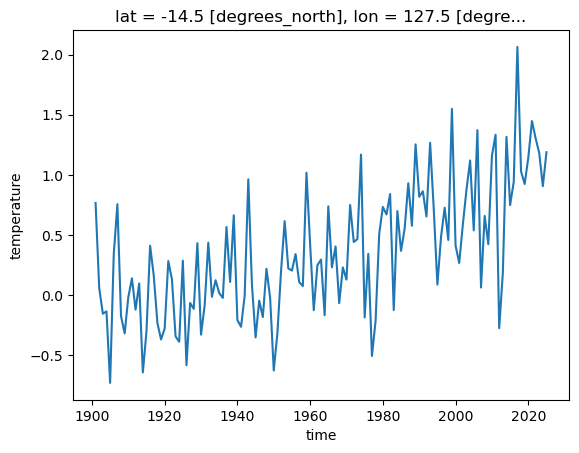

In [139]:
data_ds.sel(lat=-15, lon=127, method='nearest').plot()

Text(0.5, 1.0, 'Year 2000')

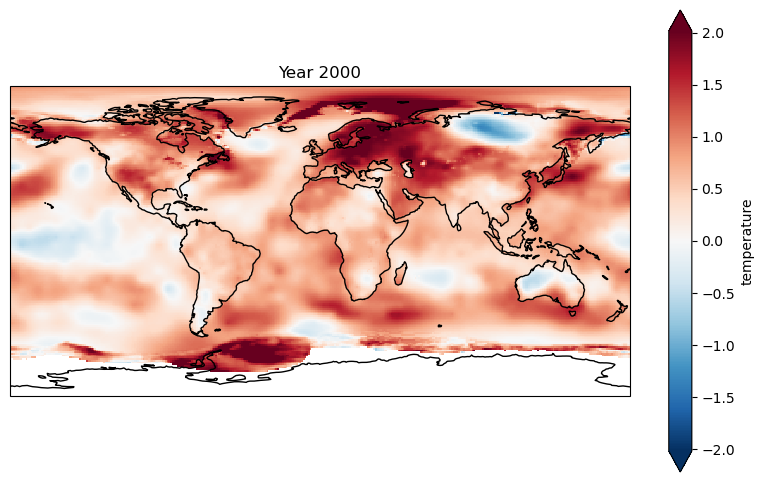

In [140]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=100).plot(ax=ax,robust=True)
ax.coastlines()
ax.set_title('Year 2000')

In [141]:
start_end_tuple = (1900, 1950)#
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)> Size: 13MB
array([[[  nan, ...,   nan],
        ...,
        [ 0.1 , ...,  0.1 ]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.32, ..., -0.32]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 400B 1900-12-31 1901-12-31 ... 1949-12-31

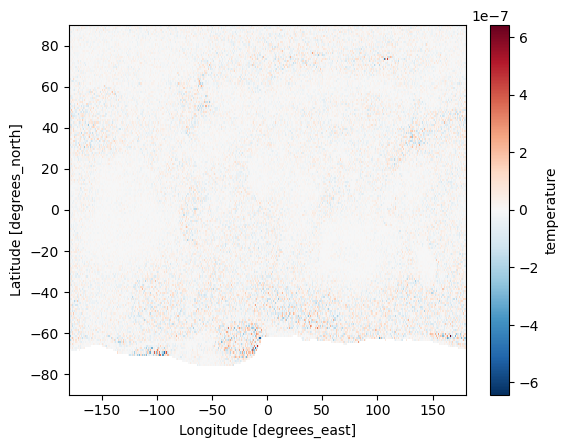

In [142]:
base_period_ds.mean(dim='time').plot()

In [143]:
base_period_ds_count = base_period_ds.count(dim='time')

In [144]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)> Size: 518kB
array([[0, ..., 0],
       ...,
       [1, ..., 1]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

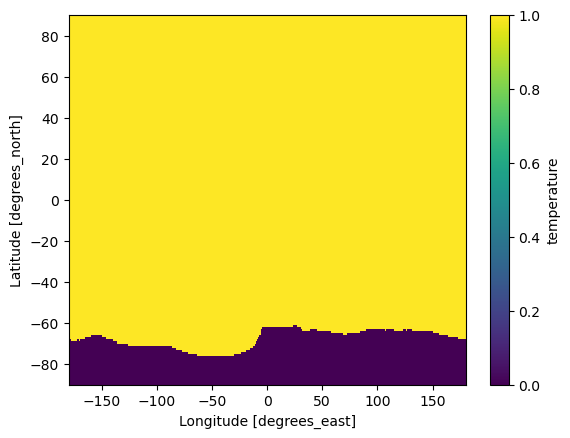

In [145]:
data_availability_mask.plot()

In [146]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [147]:
land_mask_ds = xr.open_dataarray('/g/data/w40/ab2313/PhD/time_of_emergence/best/best_mask.zarr')
land_mask_ds

<xarray.DataArray 'land_mask' (lat: 180, lon: 360)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes: (5)

# Part I: Method Comparison

## Emergence Calculation

In [148]:
# Finding when each test does not emerge
sn_does_not_emerge = (np.abs(toe_metrics_ds['sn']).isel(time=-1) <= 1)
sn_does_not_emerge_lowess = (np.abs(toe_metrics_ds['sn_lowess']).isel(time=-1) <= 1)
sn_does_not_emerge_lowess_rolling = (np.abs(toe_metrics_ds['sn_lowess_rolling']).isel(time=-1) <= 1)

sn_does_not_emerge_lowess_rolling_smooth = (np.abs(toe_metrics_ds['sn_lowess_rolling_smooth']).isel(time=-1) <= 1)


ks_does_not_emerge = (toe_metrics_ds['ks'].isel(time=-1) >= PVALUE_THESHOLD1)
ttest_does_not_emerge = (toe_metrics_ds['ttest'].isel(time=-1) >= PVALUE_THESHOLD1)
anderson_does_not_emerge = (toe_metrics_ds['anderson'].isel(time=-1) >= PVALUE_THESHOLD1)

perkins_does_not_emerge = (toe_metrics_ds['perkins'].isel(time=-1) >= OVERLAP_THRESHOLD)
frac_geom_ds_does_not_emerge = (toe_metrics_ds['frac'].isel(time=-1) >= OVERLAP_THRESHOLD)

does_not_emerge_ds = xr.merge([sn_does_not_emerge, ks_does_not_emerge,ttest_does_not_emerge , 
                               anderson_does_not_emerge, perkins_does_not_emerge,
                               frac_geom_ds_does_not_emerge, sn_does_not_emerge_lowess, sn_does_not_emerge_lowess_rolling,
                              sn_does_not_emerge_lowess_rolling_smooth])

In [149]:
sn_toe_t1_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=1, comparison_func=np.greater_equal).expand_dims(threshold=[1])
sn_toe_t2_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=2, comparison_func=np.greater_equal).expand_dims(threshold=[2])
sn_toe_t3_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=3, comparison_func=np.greater_equal).expand_dims(threshold=[3])
sn_toe_t4_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=4, comparison_func=np.greater_equal).expand_dims(threshold=[4])

In [150]:
sn_does_not_emerge_t1 = (np.abs(toe_metrics_ds['sn'].isel(time=-1)) <= 1).expand_dims(threshold=[1])
sn_does_not_emerge_t2 = (np.abs(toe_metrics_ds['sn'].isel(time=-1)) <= 2).expand_dims(threshold=[2])
sn_does_not_emerge_t3 = (np.abs(toe_metrics_ds['sn'].isel(time=-1)) <= 3).expand_dims(threshold=[3])
sn_does_not_emerge_t4 = (np.abs(toe_metrics_ds['sn'].isel(time=-1)) <= 4).expand_dims(threshold=[4])

In [151]:
toe_sn_multi_thresh_ds = xr.concat([sn_toe_t1_ds, sn_toe_t2_ds, sn_toe_t3_ds, sn_toe_t4_ds], dim='threshold')
toe_sn_multi_thresh_ds

<xarray.DataArray 'sn' (threshold: 4, lat: 180, lon: 360)> Size: 2MB
array([[[  nan, ...,   nan],
        ...,
        [1986., ..., 1986.]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]]])
Coordinates:
  * threshold  (threshold) int64 32B 1 2 3 4
  * lat        (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon        (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes: (1)

In [152]:
sn_does_not_emerge_multi_thresh_ds = xr.concat([sn_does_not_emerge_t1, sn_does_not_emerge_t2, sn_does_not_emerge_t3, 
                                                sn_does_not_emerge_t4], dim='threshold')

In [153]:
simulation_max = toe_metrics_ds.time.dt.year.values[-1] - 10
simulation_max

2004

In [154]:
# Find the year of permanent exceedance

# # The distribution overlap methods
perkins_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['perkins'], threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)
frac_geom_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['frac'], threshold=OVERLAP_THRESHOLD, comparison_func=np.less_equal)

sn_toe_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn']), threshold=1, comparison_func=np.greater_equal)
sn_toe_lowess_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn_lowess']), threshold=1, comparison_func=np.greater_equal)
sn_toe_lowess_rolling_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn_lowess_rolling']), threshold=1, comparison_func=np.greater_equal)

sn_toe_lowess_rolling_smooth_ds = toe.get_permanent_exceedance(np.abs(toe_metrics_ds['sn_lowess_rolling_smooth']), threshold=1, comparison_func=np.greater_equal)

ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds, perkins_toe_ds, frac_geom_toe_ds, 
                  sn_toe_lowess_ds, sn_toe_lowess_rolling_ds, sn_toe_lowess_rolling_smooth_ds])
# If have emerged too late, it has not emerged
toe_ds = xr.where(toe_ds<simulation_max, toe_ds, np.nan)

In [155]:
does_not_emerge_ds = xr.where(np.isnan(toe_ds),1, does_not_emerge_ds)
does_not_emerge_ds = xr.where(data_availability_mask, does_not_emerge_ds, np.nan)

In [156]:
# Make same order 
toe_metrics_ds = toe_metrics_ds[list(toe_ds.data_vars)]
toe_metrics_ds

<xarray.Dataset> Size: 490MB
Dimensions:                   (lat: 180, lon: 360, time: 105)
Coordinates:
  * lat                       (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                       (lon) float32 1kB -179.5 -178.5 ... 178.5 179.5
  * time                      (time) datetime64[ns] 840B 1910-12-31 ... 2014-...
Data variables:
    sn                        (lat, lon, time) float64 54MB nan nan ... 2.34
    ks                        (time, lat, lon) float64 54MB nan nan ... 1.82e-11
    ttest                     (time, lat, lon) float64 54MB nan ... 3.238e-15
    anderson                  (time, lat, lon) float64 54MB nan nan ... 0.001
    perkins                   (time, lat, lon) float64 54MB nan nan ... 8.0 8.0
    frac                      (time, lat, lon) float64 54MB nan nan ... 21.11
    sn_lowess                 (lat, lon, time) float64 54MB nan nan ... 2.278
    sn_lowess_rolling         (lat, lon, time) float64 54MB nan nan ... 1.944
    sn_lowess_rolling_smooth  (lat, lon, time) float64 54MB nan nan ... 2.583
Attributes: (1)

In [157]:
# Calculate an array of lat,lon, time, where there are 1s after emergenace has occured
# and zeros before emergence
# calculate_returned_binary_ds = partial(toe.calculate_returned_binary_ds, time_years=toe_metrics_ds.time.dt.year.values)

binary_emergence_ds = xr.apply_ufunc(
    toe.calculate_returned_binary_ds,
    toe_metrics_ds,
    toe_ds,
    toe_metrics_ds.time.dt.year.values,
    input_core_dims = [['time'], [], ['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized'
)

In [158]:
# TODO: Somehow, non-zero and one values get in here. This will fix
# but should not be a long-term soluation
binary_emergence_ds = xr.where(binary_emergence_ds == 1, 1, 0)
binary_emergence_ds = binary_emergence_ds.where(data_availability_mask)

In [159]:
# Calculate the percent of points stable for different reiogns
emergence_time_series_ds = toe.calculate_percent_stable_for_regions(binary_emergence_ds, land_mask_ds,
                                                                   only_1s_ds = data_availability_mask, 
                                                                    logginglevel='ERROR')

emergence_time_series_ds

<xarray.Dataset> Size: 77kB
Dimensions:                   (region: 10, time: 105)
Coordinates:
  * region                    (region) object 80B 'global' ... 'antarctic'
  * time                      (time) datetime64[ns] 840B 1910-12-31 ... 2014-...
Data variables:
    sn                        (region, time) float64 8kB 0.0 0.0 ... 74.59 74.59
    ks                        (region, time) float64 8kB 0.0 0.0 ... 24.15 24.15
    ttest                     (region, time) float64 8kB 0.0 0.0 ... 24.25 24.25
    anderson                  (region, time) float64 8kB 0.0 0.0 ... 80.17 80.17
    perkins                   (region, time) float64 8kB 0.0 0.0 ... 90.65 90.65
    frac                      (region, time) float64 8kB 0.0 0.0 ... 77.02 77.02
    sn_lowess                 (region, time) float64 8kB 0.0 0.0 ... 75.61 75.61
    sn_lowess_rolling         (region, time) float64 8kB 0.0 0.0 ... 74.3 74.3
    sn_lowess_rolling_smooth  (region, time) float64 8kB 0.0 0.0 ... 73.91 73.91
Attributes: (10)

In [160]:
# Get the signal-to-noise value at the year that the KS test emerged
find_value_at_emergence_arg_partial = partial(toe.find_value_at_emergence_arg,
                                              time_years=toe_metrics_ds.time.dt.year.values)

In [161]:
sn_at_ks_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['sn'], # Time series
    toe_ds['ks'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [162]:
sn_lowess_at_ks_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['sn_lowess'], # Time series
    toe_ds['ks'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [163]:
sn_lowess_at_overlap_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['sn_lowess'], # Time series
    toe_ds['frac'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [164]:
sn_at_overlap_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['sn'], # Time series
    toe_ds['frac'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [165]:
overlap_at_ks_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['frac'], # Time series
    toe_ds['ks'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]  
)

In [166]:
overlap_at_sn_lowess_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['frac'], # Time series
    toe_ds['sn_lowess'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]    
)

In [167]:
overlap_at_sn_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['frac'], # Time series
    toe_ds['sn'], # Year of emergence
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]    
)

In [168]:
overlap_at_ks_emergence_ds.name = 'overlap_at_ks'
overlap_at_sn_emergence_ds.name =  'overlap_at_sn'
sn_at_ks_emergence_ds.name =  'sn_at_ks'
sn_at_overlap_emergence_ds.name =  'sn_at_overlap'

overlap_at_ks_emergence_ds.attrs['long_name'] = 'Overlap at KS Emergence'
overlap_at_sn_emergence_ds.attrs['long_name'] = 'Overlap at S/N Ratio Emergence'
sn_at_ks_emergence_ds.attrs['long_name'] = 'S/N Ratio at KS Emergence'
sn_at_overlap_emergence_ds.attrs['long_name'] = 'S/N Ratio at Overlap Emergence'

(array([   12.,   273.,   563.,  1328.,  6012., 35793.,   277.,    54.,
           46.,    39.]),
 array([-54. , -44.4, -34.8, -25.2, -15.6,  -6. ,   3.6,  13.2,  22.8,
         32.4,  42. ]),
 <BarContainer object of 10 artists>)

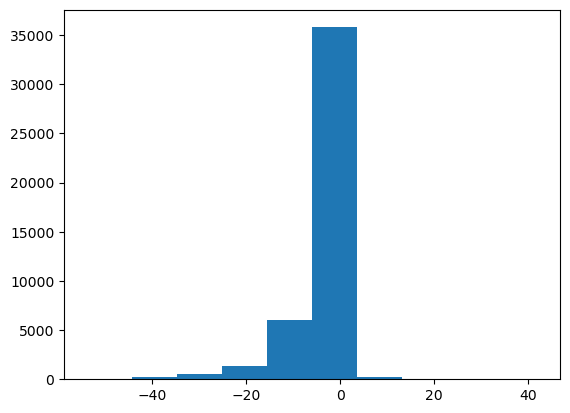

In [169]:
(toe_ds['ks'] - toe_ds['frac']).plot.hist()

In [170]:
overlap_at_sn_emergence_ds.median()

<xarray.DataArray 'overlap_at_sn' ()> Size: 8B
array(65.44)

(array([    1.,     2.,     8.,    82.,   200.,  1343., 12989., 26028.,
         6520.,   339.]),
 array([27.36, 32.54, 37.73, 42.92, 48.1 , 53.29, 58.48, 63.67, 68.85,
        74.04, 79.23]),
 <BarContainer object of 10 artists>)

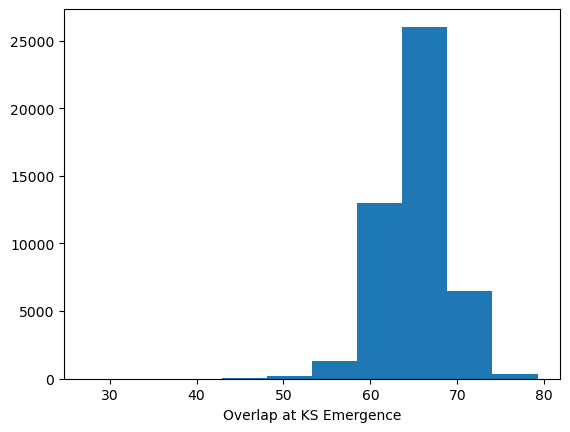

In [171]:
overlap_at_ks_emergence_ds.plot.hist()

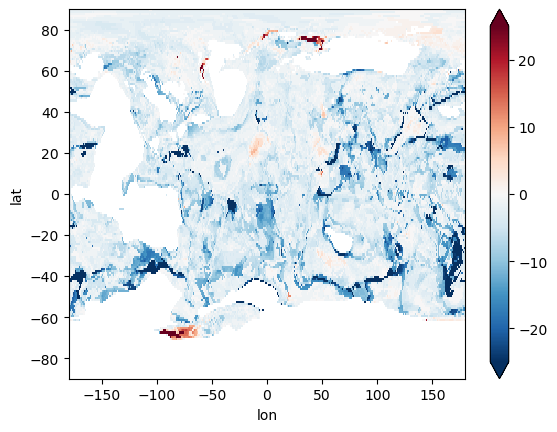

In [172]:
(toe_ds['ks'] - toe_ds['frac']).plot(robust=True)

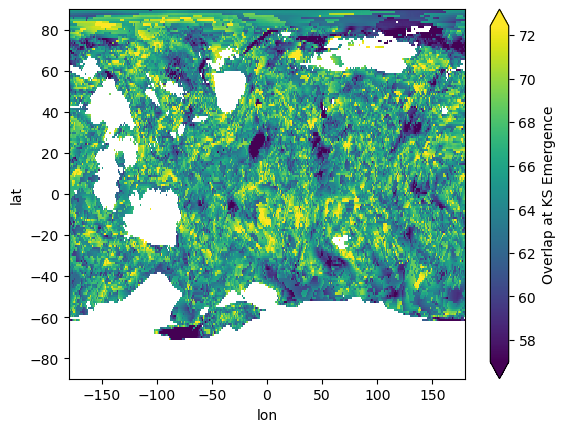

In [173]:
overlap_at_ks_emergence_ds.plot(robust=True)

## Plotting

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[ nan, ...,  nan],
        ...,
        [0.1 , ..., 0.1 ]],

       ...,

       [[ nan, ...,  nan],
        ...,
        [2.13, ..., 2.12]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1kB 1900-12-31 1901-12-31 ... 2024-12-31

In [176]:
toe_emergence_levels = np.arange(1900, data_ds.time.dt.year.values[-1]-10, 20)
toe_emergence_levels

array([1900, 1920, 1940, 1960, 1980, 2000])

In [177]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [178]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, levels=[-1, 0, 1, 2], **kwargs)

In [179]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)

In [180]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

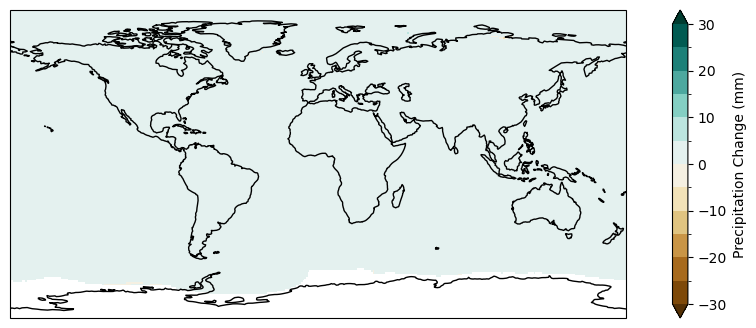

In [181]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

(data_ds.isel(time=slice(-30, None)).mean(dim='time') - data_ds.isel(time=slice(0, 50)).mean(dim='time')).plot(
    ax=ax, robust=True,  cmap='BrBG', levels=np.arange(-30, 35, 5), extend='both', cbar_kwargs=dict(label='Precipitation Change (mm)'))
ax.coastlines()


### Masks Demonstartion

In [182]:
# grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

Text(0.5, 1.0, 'Anderson')

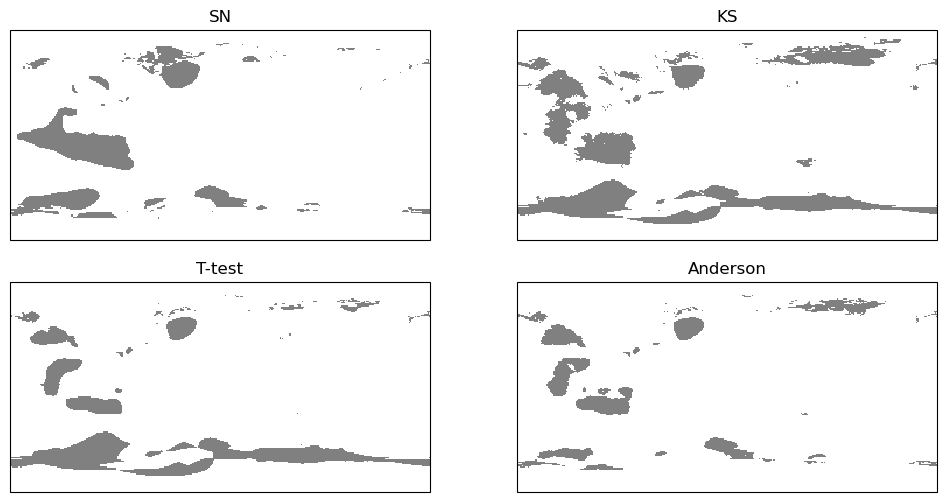

In [183]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

does_not_emerge_ds['sn'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
does_not_emerge_ds['ttest'].plot(ax=axes[2], **not_stable_kwargs2)
does_not_emerge_ds['anderson'].plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

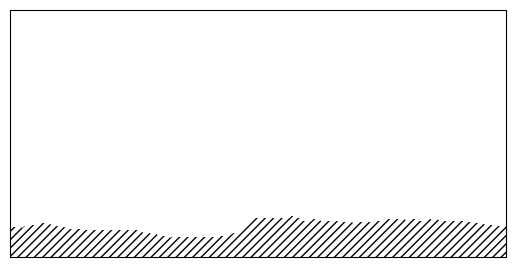

In [184]:
fig = plt.figure()
ax=fig.add_subplot(111, projection=ccrs.PlateCarree())
hatch(ax, data_unavailability_mask, **not_stable_kwargs)

### Maps

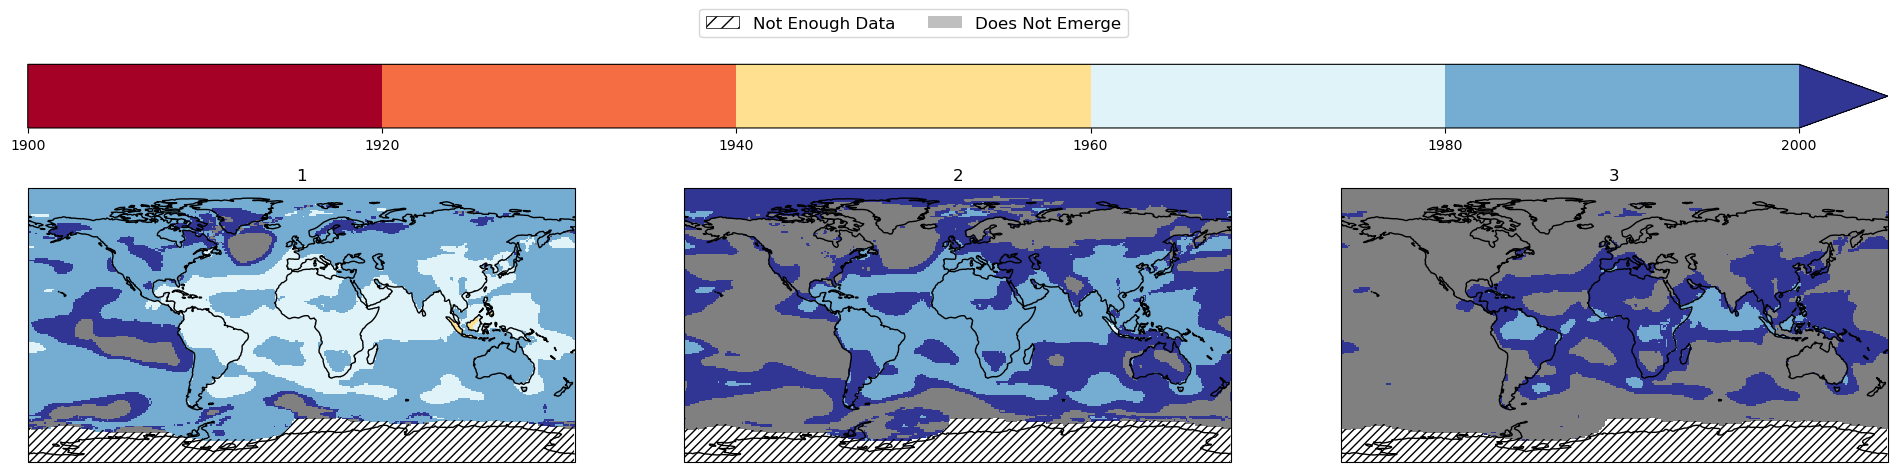

In [185]:
fig = plt.figure(figsize=(16 * 3/2, 10*(1.2/2.2)))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[.2, 1])
axes = [fig.add_subplot(gs[1, i], projection=projection) for i in range(3)]

not_stable_kwargs2 = dict(cmap= cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)# vmin=1890, vmax=2020) #viridis_r

for ax, threshold in zip(axes, toe_sn_multi_thresh_ds.threshold.values):
    sn_does_not_emerge_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_sn_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **toe_plot_kwargs)
    ax.set_title(threshold)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 2), fontsize='large', ncol=2)

In [186]:
# Define the colors and their positions
colors = [
    "#654321",  # dark brown
    "#D2B48C",  # light brown
    "#8B0000",  # dark red
    "#FF6347",  # light red
    "#ADD8E6",  # light blue
    "#00008B",  # dark blue
    "#DDA0DD",  # light purple
    "#4B0082"   # dark purple
]

# Create the colormap
# toe_cmap = mcolors.LinearSegmentedColormap.from_list("brown_red_blue_purple", colors)
toe_cmap = 'RdYlBu'

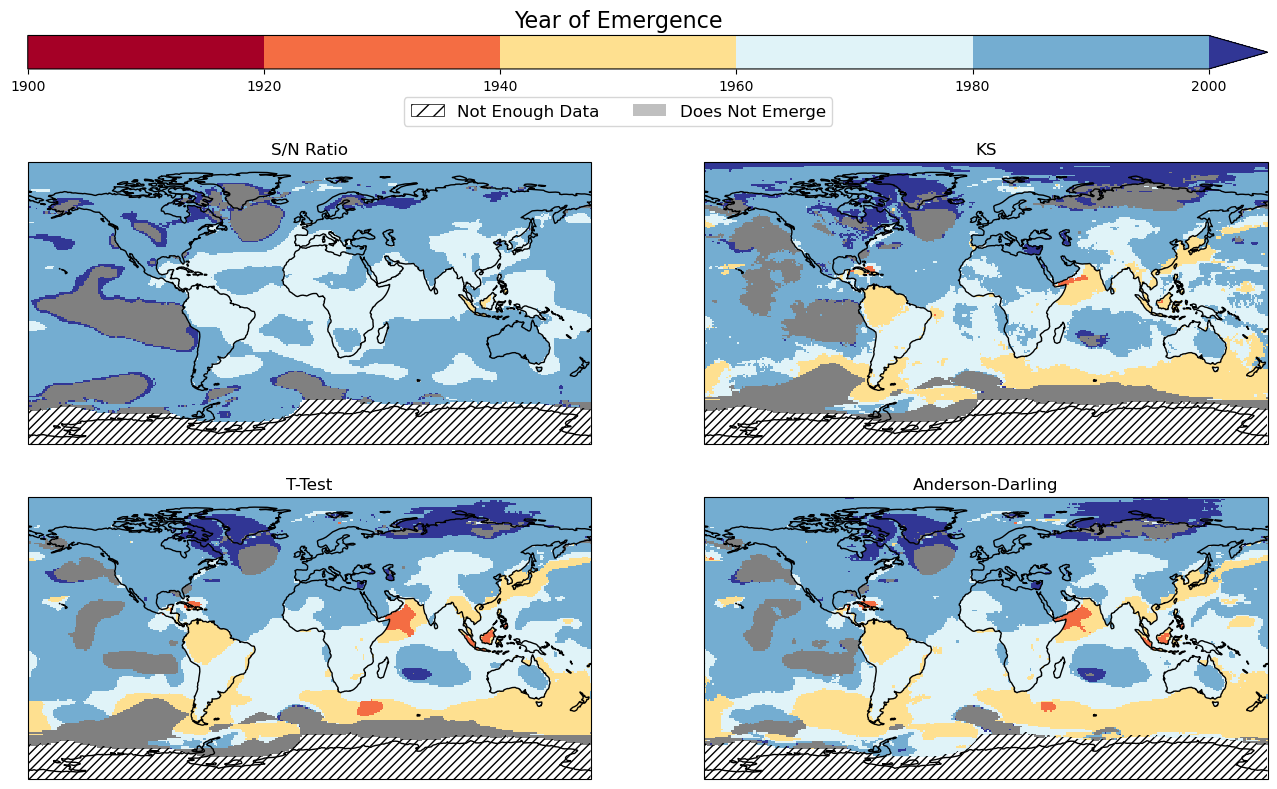

In [187]:
tests_used = ['sn', 'ks', 'ttest', 'anderson']
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[.1, .2, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 8)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap=toe_cmap,add_colorbar=False, levels=toe_emergence_levels)# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    ax.set_title( toe_const.NAME_CONVERSION_DICT.get(test, test) )#toe_ds[test].long_name)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


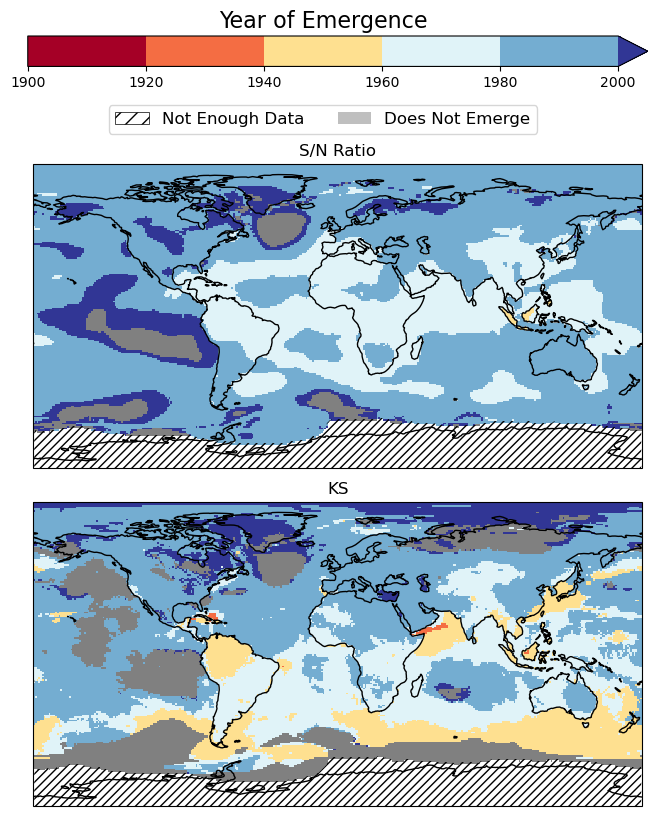

In [188]:
fig = plt.figure(figsize=(8, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 1, height_ratios=[.1, .1, 1, 1], hspace=0.2)
axes = [fig.add_subplot(gs[i+2], projection=projection) for i in range(2)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, ['sn', 'ks']):
    if test == 'sn':
        toe_sn_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **toe_plot_kwargs)
        sn_does_not_emerge_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **not_stable_kwargs2)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name + ' (threshold=1)'
    else:
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, -1), fontsize=12, ncol=2)


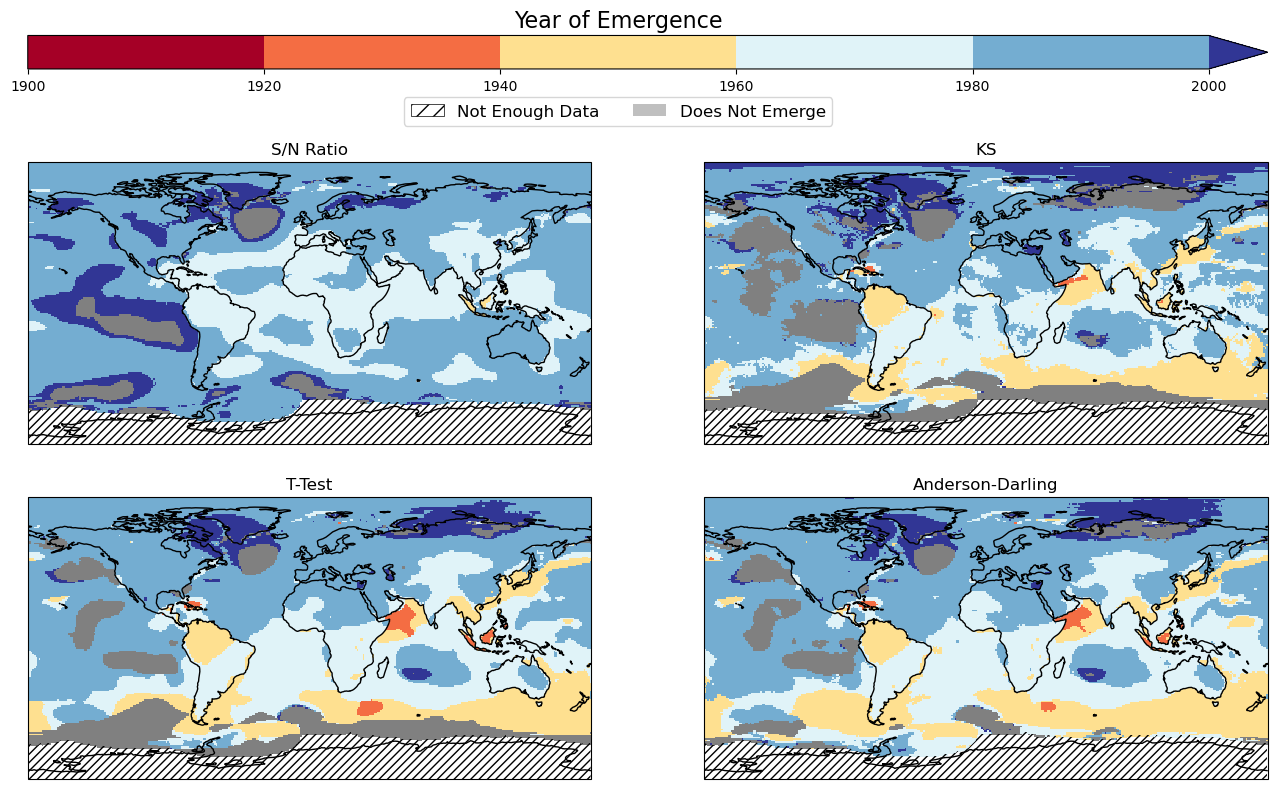

In [189]:
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[.1, .2, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 8)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    if test == 'sn':
        toe_sn_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **toe_plot_kwargs)
        sn_does_not_emerge_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **not_stable_kwargs2)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name + ' (threshold=1)'
    else:
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


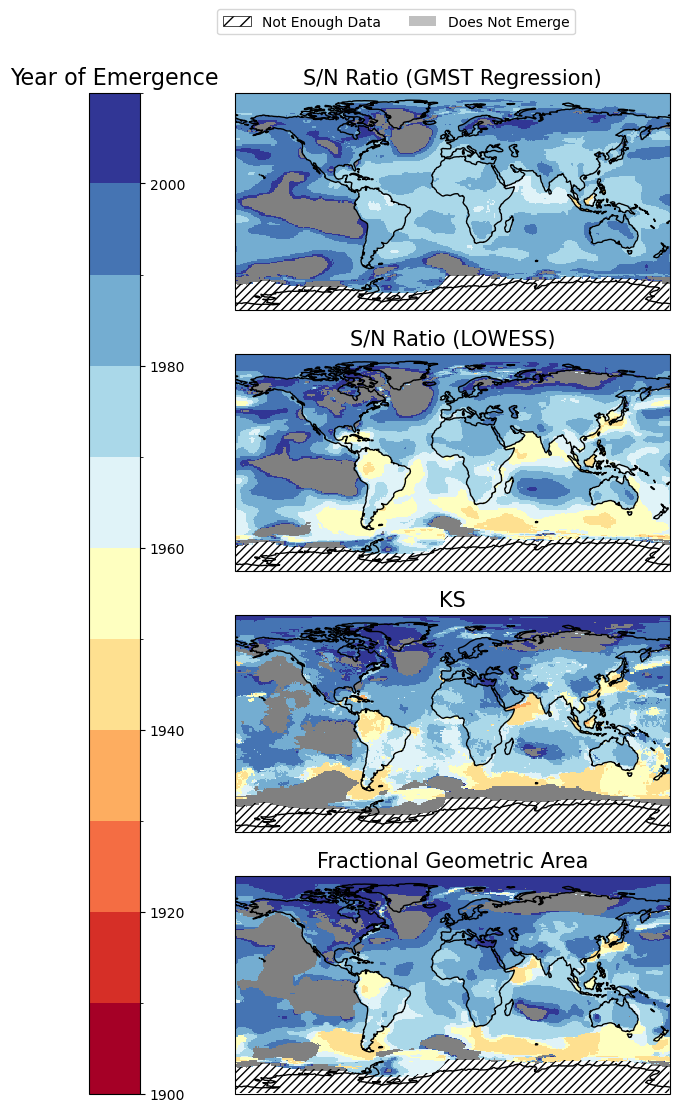

In [214]:
tests_subset_used = ['sn', 'sn_lowess', 'ks', 'frac']

fig = plt.figure(figsize=(8, 13))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)
axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(4)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1900, 2020, 10))#toe_emergence_levels vmin=1890, vmax=2020) #viridis_r



# ax = axes[1]
# sn_does_not_emerge_lowess.plot(ax=ax, **not_stable_kwargs2)
# sn_toe_lowess_rolling_ds.plot(ax=ax, **toe_plot_kwargs)
# title =  'S/N Ratio (LOWESS)'#toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
# ax.set_title(title, fontsize=15)
# ax.coastlines()
# hatch(ax, data_unavailability_mask, **not_stable_kwargs)

for ax, test in zip(axes, tests_subset_used):

    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    if test == 'sn': title = f'{title} (GMST Regression)'
    ax.set_title(title, fontsize=15)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)



cbar_axes1 = plt.subplot(gs[:, 0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)

In [212]:
tests_used

['sn',
 'ks',
 'ttest',
 'anderson',
 'perkins',
 'frac',
 'sn_lowess',
 'sn_lowess_rolling',
 'sn_lowess_rolling_smooth']

Text(0.5, 1.0, 'S/N Ratio')

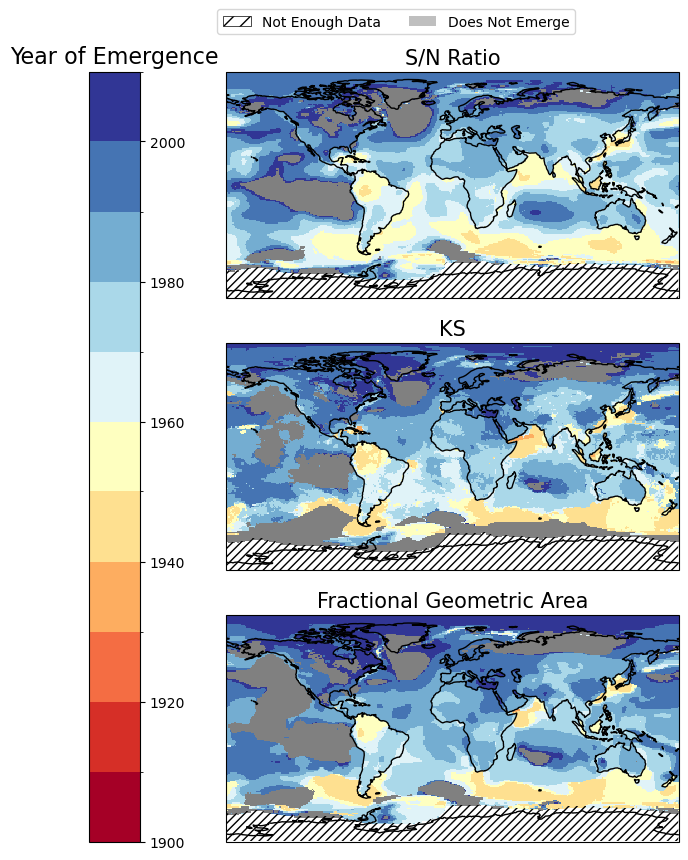

In [216]:
tests_used = ['sn_lowess', 'ks', 'frac']

fig = plt.figure(figsize=(8, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[0.1, 1], hspace=0.2, wspace=0.2)
axes = [fig.add_subplot(gs[i, 1], projection=projection) for i in range(3)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1900, 2020, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):

    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title, fontsize=15)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[:, 0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(6, 1.09), fontsize=10, ncol=2)


axes[0].set_title('S/N Ratio', fontsize=15)

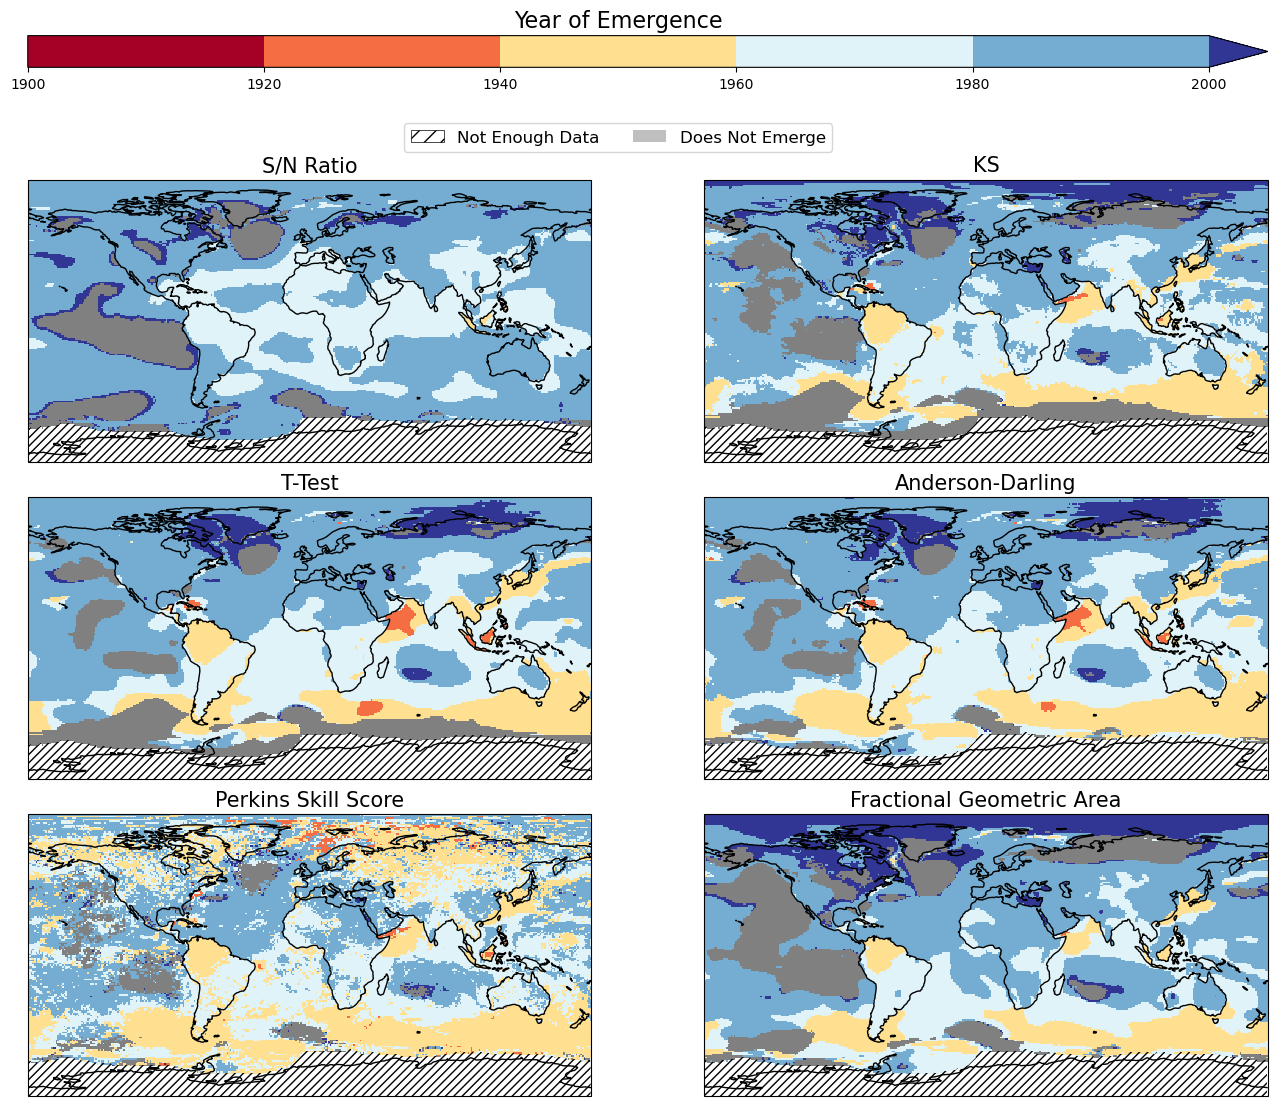

In [192]:

tests_used = list(toe_ds.data_vars)

fig = plt.figure(figsize=(16, 14))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(5, 2, width_ratios=[1, 1], height_ratios=[.1, .3, 1, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 10)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=toe_emergence_levels)# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):

    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    title =  toe_const.NAME_CONVERSION_DICT.get(test, test) #toe_ds[test].long_name
    ax.set_title(title, fontsize=15)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, -1.5), fontsize=12, ncol=2)


### Correlations and Distributions

In [193]:
# test_pattern_correlation_sn1_df = toe.data_var_pattern_correlation_all_combs(xr.merge([
#     toe_sn_multi_thresh_ds.sel(threshold=1), toe_ds[['ks', 'ttest', 'anderson']]]))

# test_pattern_correlation_all_mets_and_lowess_df = toe.data_var_pattern_correlation_all_combs(
#     xr.merge([toe_ds, sn_toe_lowess_ds])
# )

In [194]:
test_pattern_correlation_all_mets_df = toe.data_var_pattern_correlation_all_combs(toe_ds)

In [217]:
test_pattern_correlation_original_mets_df = toe.data_var_pattern_correlation_all_combs(
    toe_ds[['sn_lowess', 'ks', 'ttest', 'anderson', 'frac']])

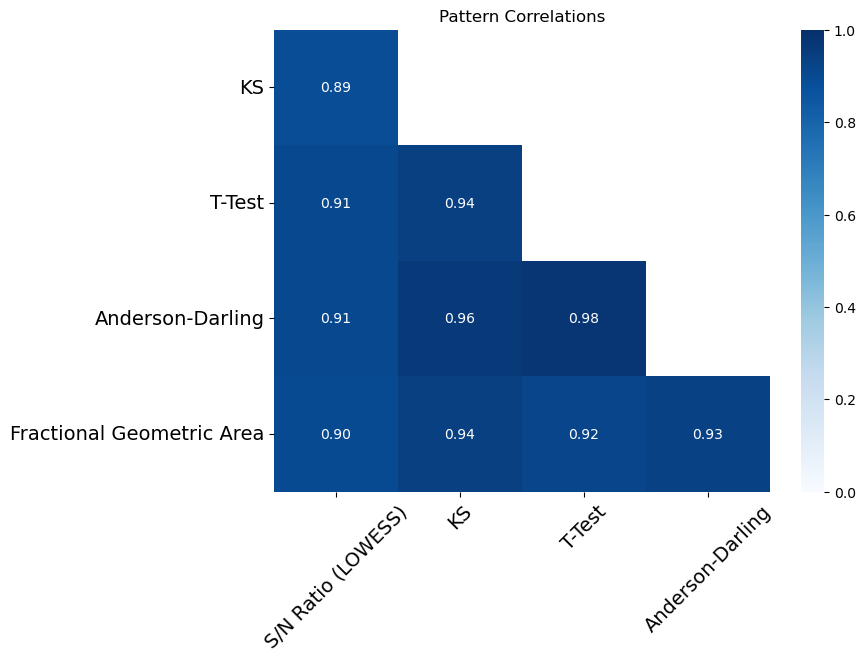

In [218]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_original_mets_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45, fontsize=14);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=14) ;  # Keep y-axis labels horizontal

In [197]:
# area_weights = np.cos(np.radians(toe_sn_multi_thresh_ds.lat))
# xr.corr(toe_sn_multi_thresh_ds.sel(threshold=1), toe_ds['ks'], weights=area_weights)

In [198]:
reload(toe_const);
reload(time_of_emergence_plots);

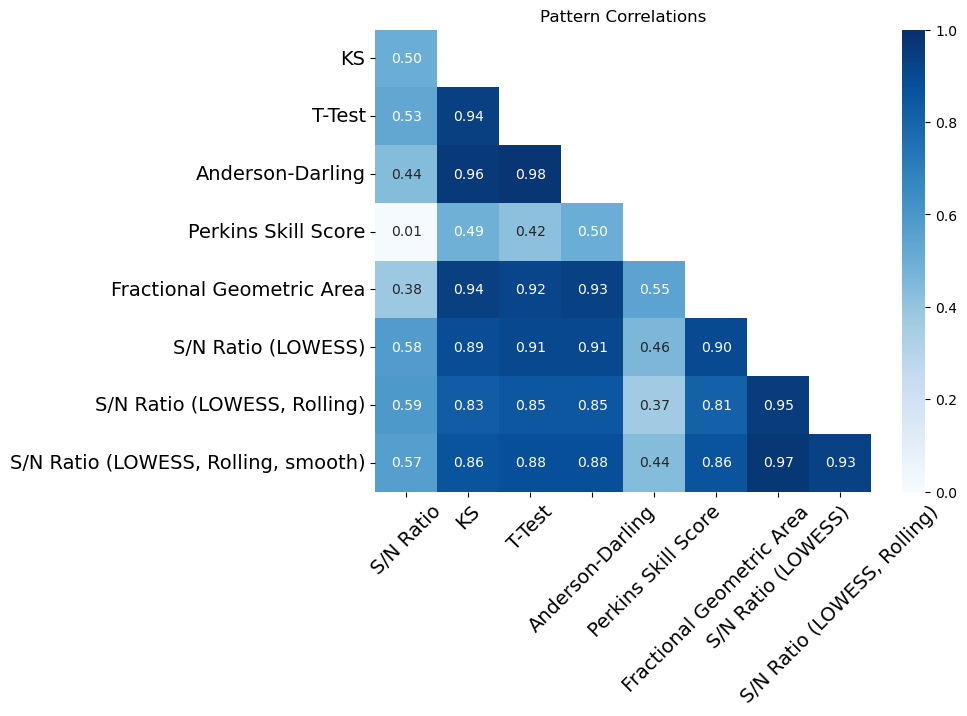

In [199]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_all_mets_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45, fontsize=14);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0, fontsize=14) ;  # Keep y-axis labels horizontal

In [200]:
# plt.figure(figsize=(8, 6))
# heatmap = sns.heatmap(test_pattern_correlation_sn1_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# # Change the ticks to long names
# heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
# heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

# plt.title('Pattern Correlations');
# plt.xticks(rotation=45);  # Rotate x-axis labels for better readability
# plt.yticks(rotation=0) ;  # Keep y-axis labels horizontal

In [201]:
# tests_used = list(toe_ds.data_vars)

# fig = plt.figure(figsize=(10, 15))

# gs = gridspec.GridSpec(len(tests_used), 1, hspace=0.5)
# axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used))]

# bins = np.arange(1900, 2025, 5)
# for ax, test in zip(axes, tests_used):
#     print(test + ', ',  end='')
#     ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
#     ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
#     title = toe_const.NAME_CONVERSION_DICT.get(test, test)#toe_ds[test].long_name 
#     if test == 'sn': title = f'{title} (threshold = 1)'
#     ax.set_title(title)
#     ax.set_xlabel('Year', fontsize=12)
#     ax.set_ylabel('Relative Frequency', fontsize=12)
#     ax.set_ylim([0, 0.05])
#     #ax.tick_params(axis='x', size=12)
    


In [202]:
# fig = plt.figure(figsize=(10, 15))

# gs = gridspec.GridSpec(len(tests_used)+1, 1, hspace=0.5)
# axes = [fig.add_subplot(gs[i]) for i in range(2)]

# ax = axes[1]
# test = 'ks'
# ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
# ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
# title = toe_const.NAME_CONVERSION_DICT.get(test, test)
# if test == 'sn': title = f'{title} (threshold = 2)'
# ax.set_title(title)
# ax.set_xlabel('Year', fontsize=12)
# ax.set_ylabel('Relative Frequency', fontsize=12)
# ax.set_ylim([0, 0.05])
    
# ax = axes[0]
# ax.grid(alpha=0.5, zorder=0)
# ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True);
# title = toe_const.NAME_CONVERSION_DICT.get('sn', 'sn')#toe_ds['sn'].long_name
# title = f'{title} (threshold = 1)'
# ax.set_title(title)
# ax.set_xlabel('Year', fontsize=12)
# ax.set_ylabel('Relative Frequency', fontsize=12)
# ax.set_ylim([0, 0.05])

NameError: name 'bins' is not defined

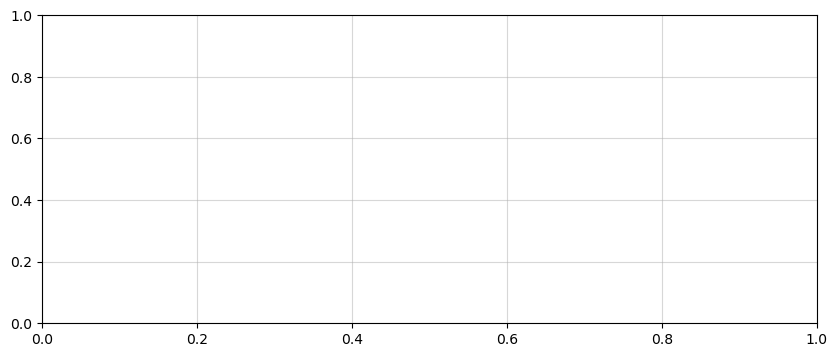

In [203]:
fig, ax = plt.subplots(figsize=(10, 4))


test = 'ks'
ax.grid(alpha=0.5, zorder=1)  # Set z-order for the grid lines
ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True, label=toe_const.NAME_CONVERSION_DICT.get(test, test))

    
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True, label='sn');
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])
ax.legend()

In [ ]:
fig = plt.figure(figsize=(10, 14))

gs = gridspec.GridSpec(len(tests_used)+1, 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used)+1)]
bins = np.arange(1900, 2025, 5)
for ax, test in zip(axes[1:], tests_used):
    ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
    ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
    title = toe_const.NAME_CONVERSION_DICT.get(test, test) 
    if test == 'sn': title = f'{title} (threshold = 2)'
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Relative Frequency')
    ax.set_ylim([0, 0.05])
    
ax = axes[0]
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True);
title = toe_const.NAME_CONVERSION_DICT.get('sn', 'sn')#toe_ds['sn'].long_name
title = f'{title} (threshold = 1)'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])

### Time Series

In [204]:
REGION_STYLE_DICT = {
    'land': {'color': 'brown', 'linestyle': '--'}, 
    'ocean': {'color': 'blue', 'linestyle': '--'},
    'nh': {'color': 'm', 'linestyle': (0, (1, 1))}, 
    'sh': {'color': 'orange', 'linestyle': (0, (1, 1))},
    'tropics': {'color': 'darkgreen', 'linestyle': '--'}, 
    'mid_lat_nh': {'color': 'red', 'linestyle': '-'}, 
    'mid_lat_sh': {'color': 'tomato', 'linestyle': '--'},
    'arctic': {'color': 'lightblue', 'linestyle': '-'}, 
    'antarctic': {'color': 'darkblue'},
    'global': {'color': 'black', 'linestyle': '-', 'linewidth': 5, 'zorder': 100}
}


Text(0.5, 0, 'Time')

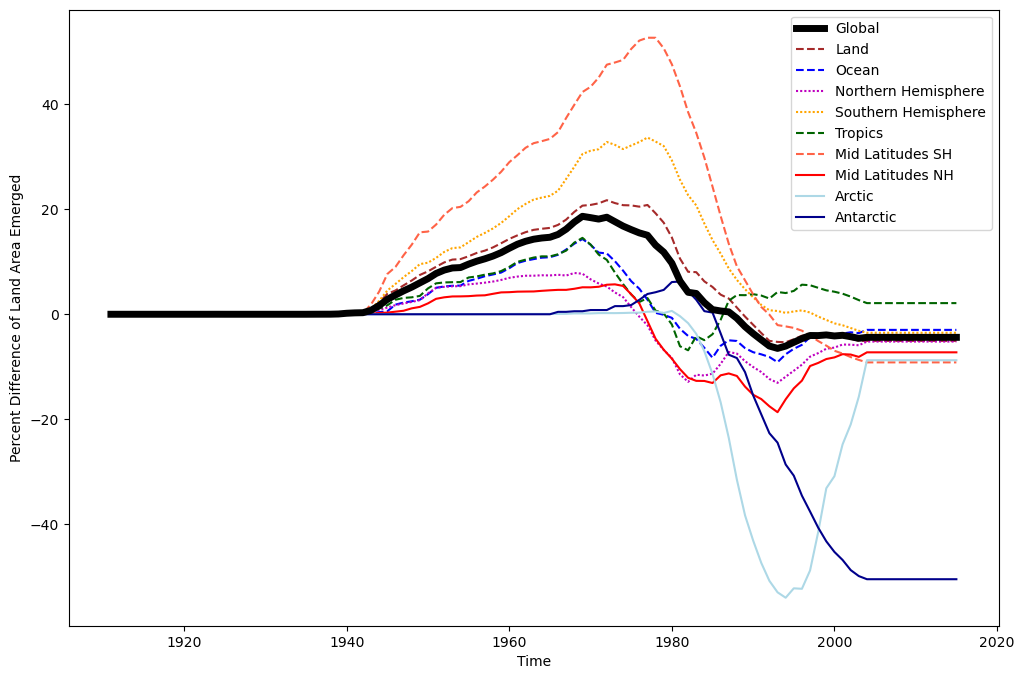

In [205]:
fig, ax = plt.subplots(figsize=(12, 8))
ks_sn_time_series_diff_ds = (emergence_time_series_ds['ks'] - emergence_time_series_ds['sn'])

time = ks_sn_time_series_diff_ds.time.values
for region in ks_sn_time_series_diff_ds.region.values:
    ax.plot(time, ks_sn_time_series_diff_ds.sel(region=region).values, **REGION_STYLE_DICT.get(region, ''),
           label=toe_const.NAMING_MAP.get(region, region))

ax.legend()
ax.set_ylabel('Percent Difference of Land Area Emerged')
ax.set_xlabel('Time')

In [206]:
xr.corr(emergence_time_series_ds['sn'], emergence_time_series_ds['ks'], dim='time')

<xarray.DataArray (region: 10)> Size: 80B
array([0.98, 0.97, 0.99, 0.99, 0.94, 0.99, 0.86, 0.99, 0.92, 0.96])
Coordinates:
  * region   (region) object 80B 'global' 'land' ... 'arctic' 'antarctic'

In [207]:
xr.corr(emergence_time_series_ds['sn_lowess'], emergence_time_series_ds['ks'], dim='time')

<xarray.DataArray (region: 10)> Size: 80B
array([0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.98])
Coordinates:
  * region   (region) object 80B 'global' 'land' ... 'arctic' 'antarctic'

In [225]:
time.dt.year

<xarray.DataArray 'year' (time: 105)> Size: 840B
array([1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])
Coordinates:
  * time     (time) datetime64[ns] 840B 1910-12-31 1911-12-31 ... 2014-12-31

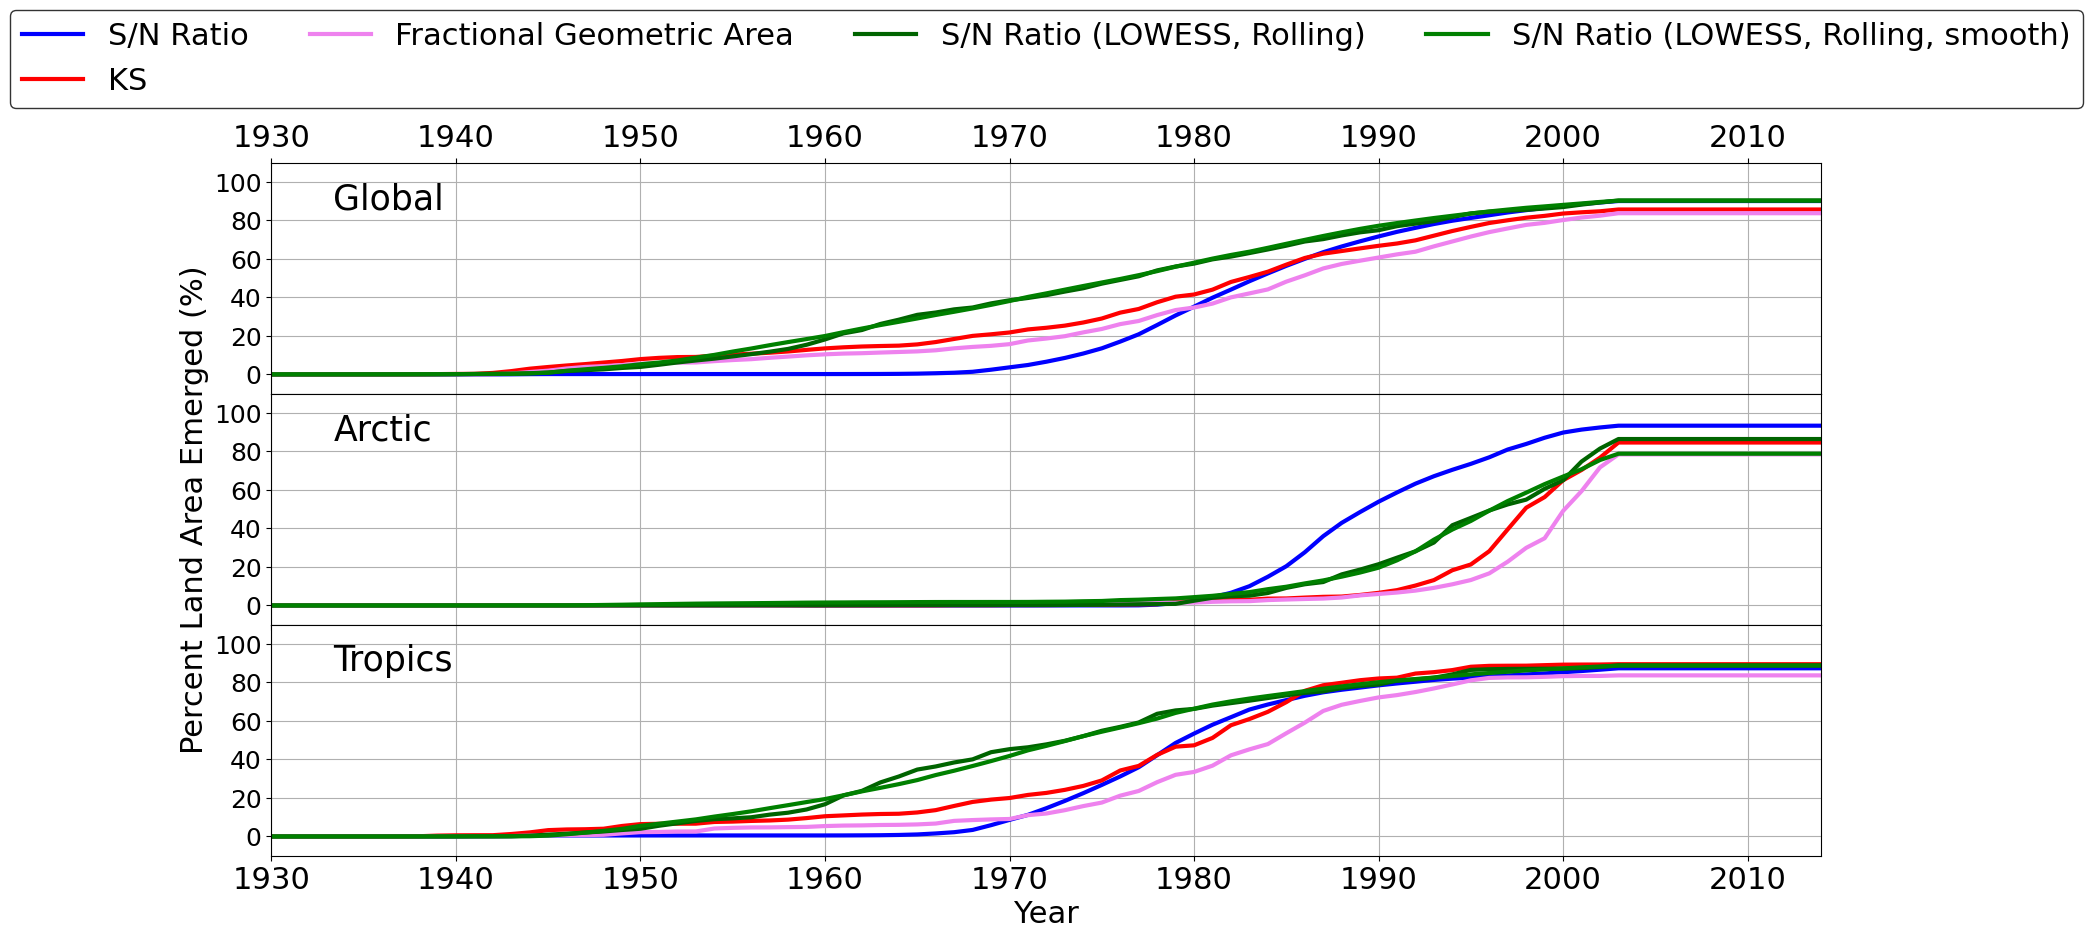

In [236]:
### Plot Creation
region_subset = ['global', 'arctic', 'tropics']# ,'mid_lat_sh']#'sh']
test_subset = ['sn_lowess', 'ks', 'frac', 'sn_lowess_rolling', 'sn_lowess_rolling_smooth']
# test_subset = ['sn', 'ks', 'frac', 'sn_lowess_rolling', 'sn_lowess_rolling_smooth']#, 'sn_lowess']
regions = region_subset
nplots = len(regions)
fig = plt.figure(figsize=(20, 3 * nplots))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]
# axes.insert(0, fig.add_subplot(gs[0])) # Insert a large subplot at the strage

time = emergence_time_series_ds.time[20:].dt.year
# time = emergence_time_series_ds.time
# time = pd.to_datetime(time)

# No emergence before 1930, so can subset
# time = list(filter(lambda x: x.dt.year>=1930, time))

for num, region in enumerate(regions):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in test_subset:
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].sel(time=region_emergence_ds.time.dt.year>=1930).values,
                color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    percent_available = (number_of_points/int(emergence_time_series_ds.attrs[region]['maximimum'])) *100
    ax.annotate(toe_const.NAMING_MAP.get(region, region), #+ f' (n={number_of_points}, {percent_available:.0f}%)'
                xy=(0.04, 0.8), size=25, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_ylim(-10, 110)
    ax.set_xlim(*np.take(time, [0, -1]))


    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # # Then getting every second one/
    tick_locations = list(filter(lambda t: t % 20 == 0, time))[::2]
    # ax.set_xticks(tick_locations)
    
    # tick_labels = list(map(lambda t:t, tick_locations))
    # ax.set_xticklabels(tick_labels)

    if num in [0]: ax.xaxis.tick_top()
    if num == 1: ax.set_ylabel('Percent Land Area Emerged (%)', fontsize=22)

    # Remove all x-ticks but the first and last
    if not (num in [0, len(regions)-1]): ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.45), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


In [237]:
reload(time_of_emergence_plots)

<module 'time_of_emergence_plots' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emergence_plots.py'>

global


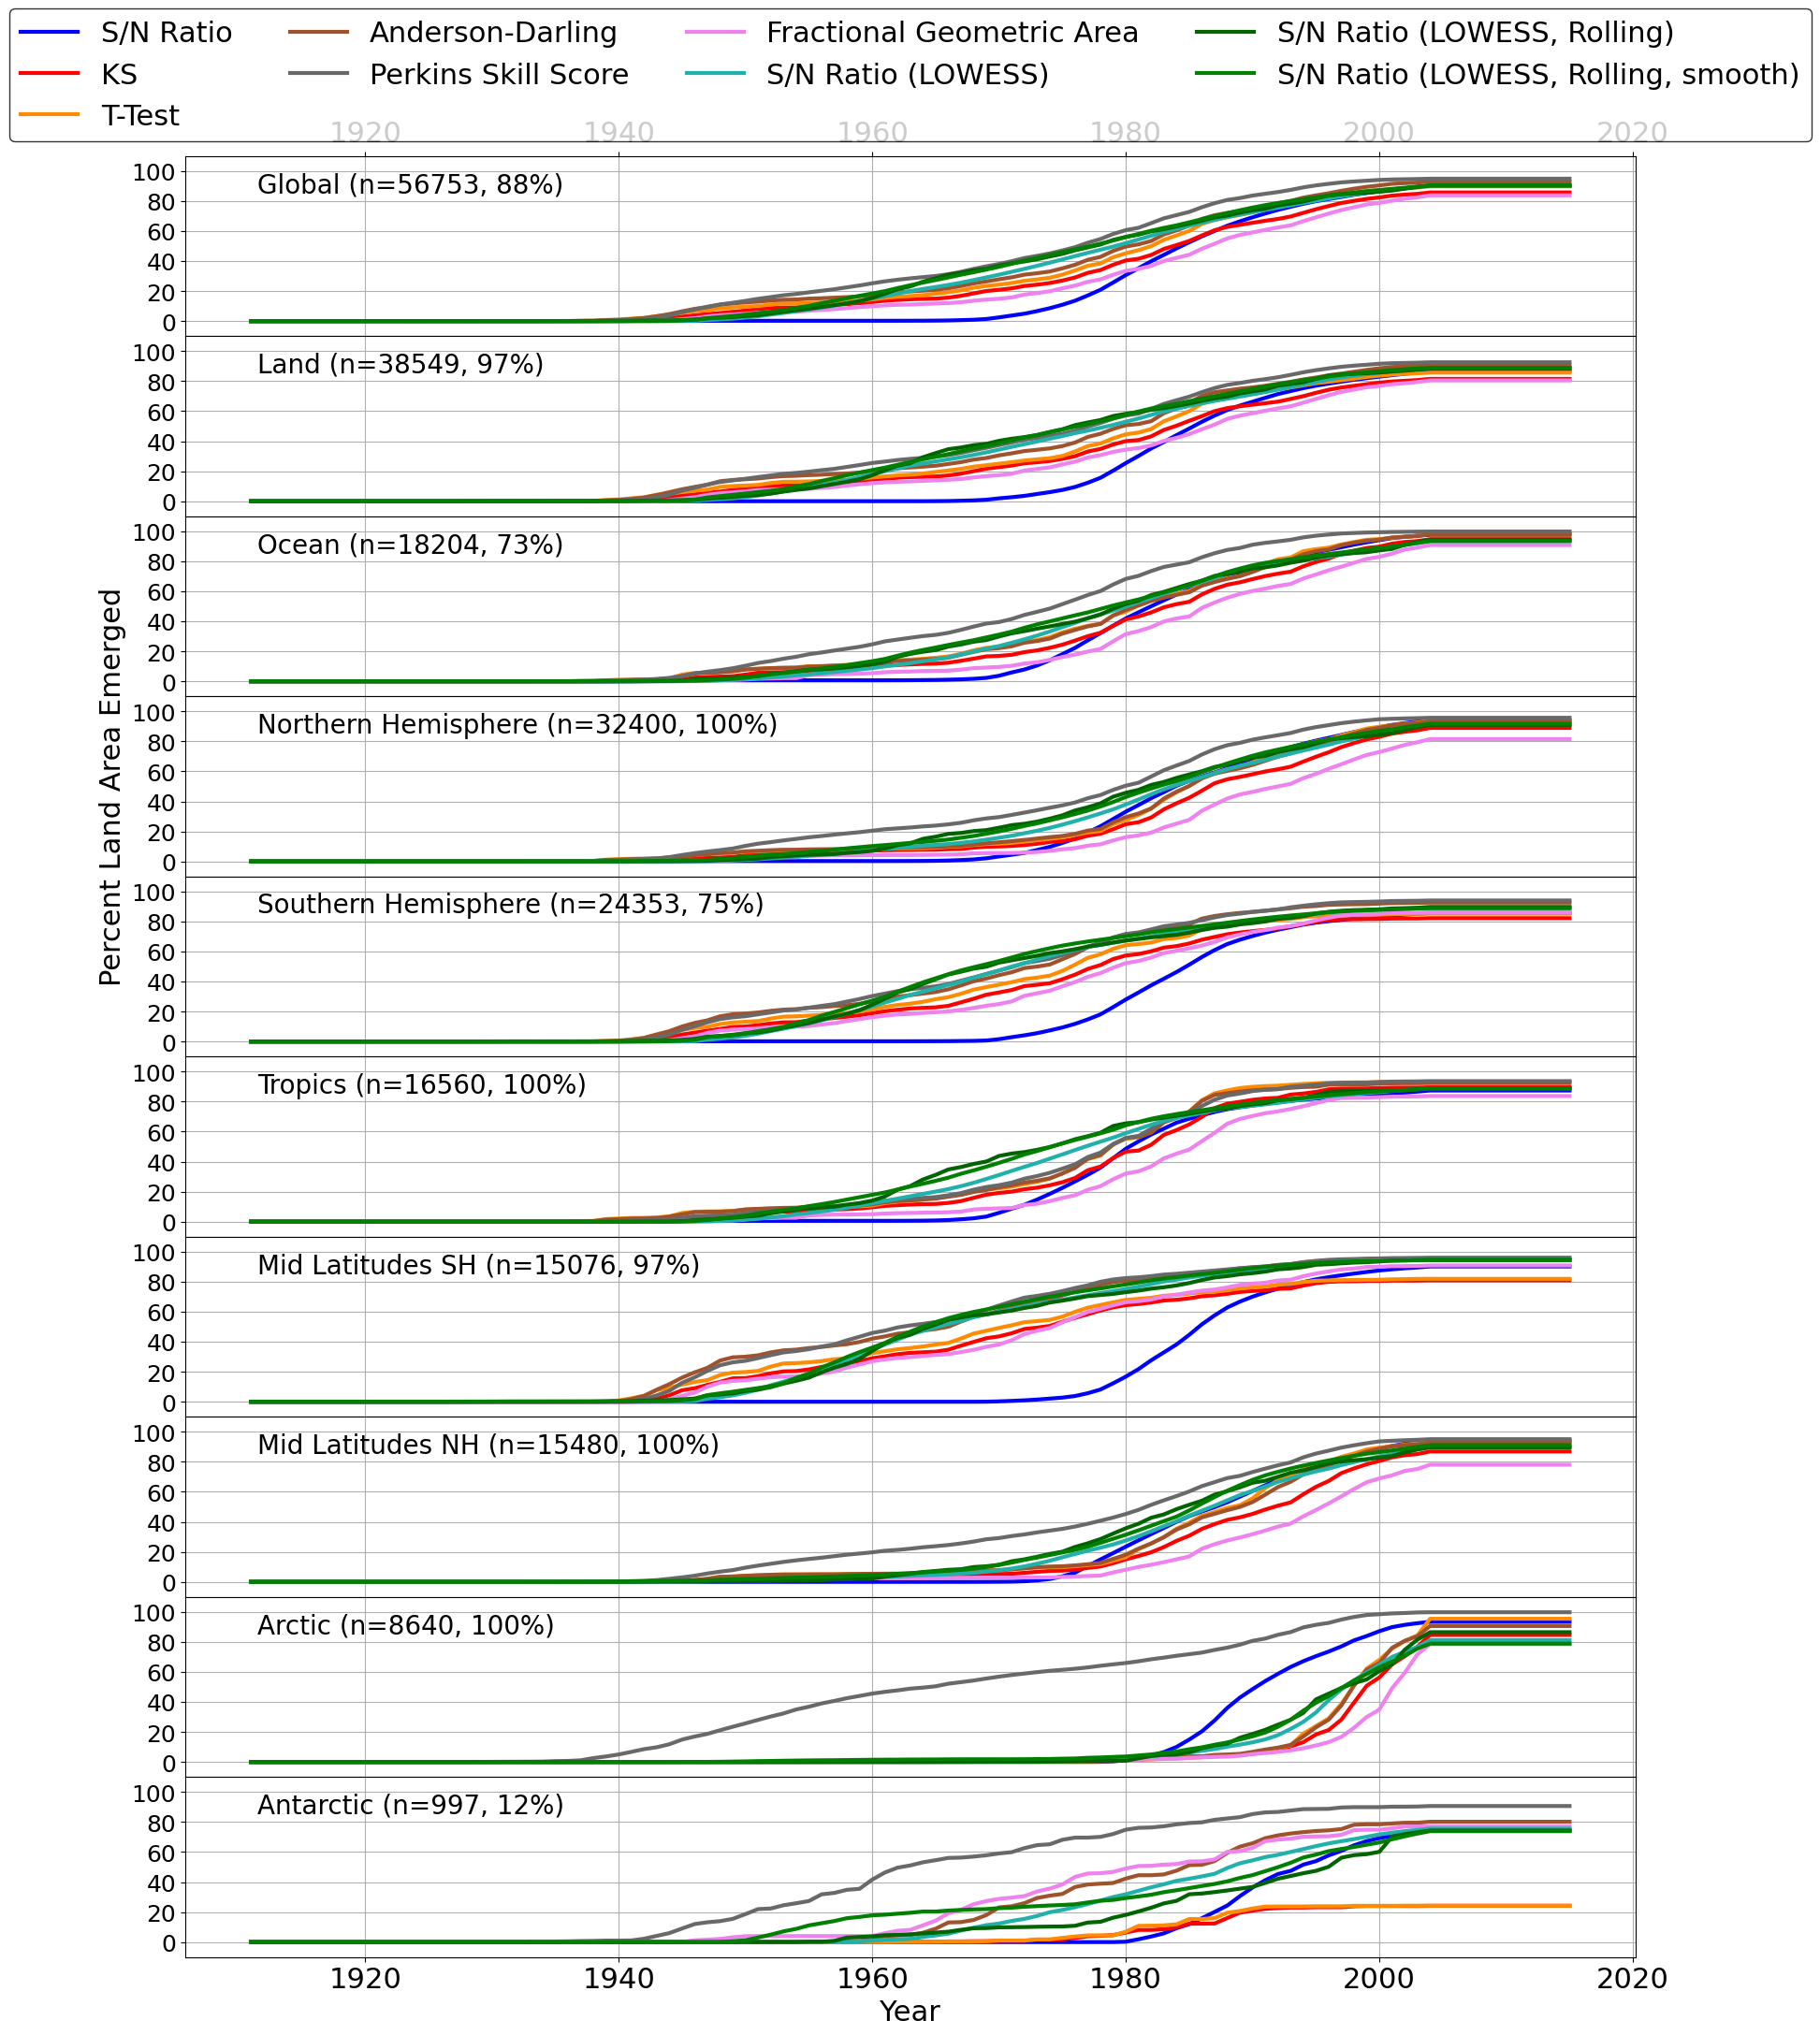

In [239]:
### Plot Creation
regions = emergence_time_series_ds.region.values
nplots = len(regions)


fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]
# axes.insert(0, fig.add_subplot(gs[0])) # Insert a large subplot at the strage

time = emergence_time_series_ds.time.values
# time = pd.to_datetime(time)

for num, region in enumerate(regions):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in list(region_emergence_ds.data_vars):
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].values, color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    percent_available = (number_of_points/int(emergence_time_series_ds.attrs[region]['maximimum'])) *100
    ax.annotate(toe_const.NAMING_MAP.get(region, region) + f' (n={number_of_points}, {percent_available:.0f}%)', xy=(0.05, 0.8), size=20, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))
    ax.set_ylim(-10, 110)


    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    # tick_locations = list(filter(lambda t: t.year % 20 == 0, time))[::2]
    # ax.set_xticks(tick_locations)
    # ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    if num in [0]:
        print(region)
        ax.xaxis.tick_top()
    if num == 3: ax.set_ylabel('Percent Land Area Emerged', fontsize=22)


    # Remove all x-ticks but the first and last
    if not (num in [0, len(regions)-1]): ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.45), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


In [ ]:
emergence_time_series_ds.attrs[region]

In [ ]:
### Plot Creation
nplots = len(emergence_time_series_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.3] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

time = emergence_time_series_ds.time.values

for num, region in enumerate(emergence_time_series_ds.region.values):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in list(region_emergence_ds.data_vars):
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].values, color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    ax.annotate(toe_const.NAMING_MAP.get(region, region) + f' (n={number_of_points})', xy=(0.05, 0.89), size=30, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))#np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.set_ylim(-5, 105)

    # Mticker seems to be broken. Not returning the correct year at the correct points

    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    tick_locations = list(filter(lambda t: t.year % 10 == 0, time))[::2]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    if num in [1,2]:
        print(region)
        ax.xaxis.tick_top()
    
    if not num%2 and num >1:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    else: ax.set_ylabel('Percent Land\nArea Emerged', fontsize=22)

    if 2 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.06), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


### Emergence Correspondense

In [241]:
from scipy.stats import gaussian_kde

In [242]:
def generate_histogram(arr: np.ndarray, bins: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a histogram from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the histogram from.
    bins (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing the bin centers, the histogram values, and the histogram normalization factor.
    """
    # Remove NaN values from the input array
    vals = arr[np.isfinite(arr)]
    
    # Generate the histogram
    hist, bin_edges = np.histogram(vals, bins=bins, density=True)
    
    # Calculate the histogram normalization factor
    hist_norm = np.sum(hist)
    
    # Normalize the histogram
    hist = hist/hist_norm
    
    # Calculate the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    return bin_centers, hist, hist_norm


def generate_kde(arr: np.ndarray, hist_norm: float, bin_edges: np.ndarray) -> tuple[gaussian_kde, np.ndarray]:
    """
    Generate a kernel density estimate (KDE) from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the KDE from.
    hist_norm (float): The histogram normalization factor.
    bin_edges (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[gaussian_kde, np.ndarray]: A tuple containing the KDE generator and the normalized KDE values.
    """
    # Generate the KDE
    arr = arr[np.isfinite(arr)]
    kde_generator = gaussian_kde(arr)
    
    # Generate a grid of x values for the KDE
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    
    # Evaluate the KDE at the x grid points
    kde_values = kde_generator(x_grid)
    
    # Normalize the KDE values
    kde_values_normalized = kde_values/hist_norm
    
    return kde_generator, kde_values_normalized

In [243]:
def plot_histogram_and_kde(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized,
                   data, fig=None, ax=None, *args, **kwargs):
    """
    Plots a histogram and kernel density estimate (KDE) for the input data.

    Parameters:
    bin_centers (array): The bin centers for the histogram.
    histogram (array): The histogram values.
    histogram_norm (float): The normalization factor for the histogram.
    kde_generator (function): The KDE generator function.
    kde_values_normalized (array): The normalized KDE values.
    data (DataFrame): The input data.

    Returns:
    fig, ax (tuple): The figure and axis objects for the plot.
    """
    if fig is None and ax is None:
        fig, ax = plt.subplots()

    # Plot the histogram with bars of width equal to the bin width
    # (accounting for floating point errors)
    ax.bar(bin_centers, histogram, width=np.unique(np.diff(bin_centers))[0].round(2), alpha=0.5)
    
    # Generate x values for the KDE plot
    x_grid = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    
    # Plot the KDE
    ax.plot(x_grid, kde_values_normalized, label='KDE', color='black')
    
    # Set the axis labels and title
    ax.set_ylabel('Relative Frequency', fontsize=20)
    ax.set_xlabel(kwargs.get('xlabel','Value'))
    ax.grid(True, alpha=0.3, color='grey', linestyle='--')

    # Calculate and plot the quantiles
    quantiles = {}
    percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
    for q in percentiles:
        qval = np.nanpercentile(data, q*100).round(2).item()
        quantiles[q] = qval
        rf_val = kde_generator(qval).item()/ histogram_norm
        if q==0.5: style_dict = dict(linewidth=3, color='k')
        elif q==0.25 or q==0.75: style_dict = dict(linewidth=2, color='k', linestyle='--')
        elif q ==percentiles[0] or q==percentiles[-1]: style_dict = dict(linewidth=2, color='k', linestyle=':')

        # Plot the quantiles as vertical lines
        ax.plot([qval, qval], [0, rf_val], **style_dict)

        # round_number = lambda n: round(n - 0.05) if n % 10 != 0 else round(n)
        # ax.annotate(round_number(qval), xy=(qval+0.025*np.max(bincenters), 0),
        #             size=16, ha='center')

    print(quantiles)
    
    return fig, ax

In [244]:
def calculate_and_plot_histogram(data, bins, fig=None, ax=None, **kwargs):
    """
    Plots the distribution of values.

    Parameters:
    data (array-like): The data to plot.
    bins (array-like): The bins for the histogram.
    xlabel (str, optional): The label for the x-axis. Defaults to 'Distribution Overlap (%)'.

    Returns:
    fig, ax: The figure and axis objects for the plot.
    """
    bin_centers, histogram, histogram_norm = generate_histogram(data.flatten(), bins)
    kde_generator, kde_values_normalized = generate_kde(data.flatten(), histogram_norm, bin_centers)
    fig, ax = plot_histogram_and_kde(bin_centers, histogram, histogram_norm, kde_generator, kde_values_normalized, 
                             data, fig=fig, ax=ax)
    
    ax.set_title(kwargs.get('title', ''), fontsize=25)
    ax.set_xlabel(kwargs.get('xlabel', ''), fontsize=20)

    return fig, ax

{0.05: 51.16, 0.25: 61.05, 0.5: 68.25, 0.75: 74.79, 0.95: 82.81}


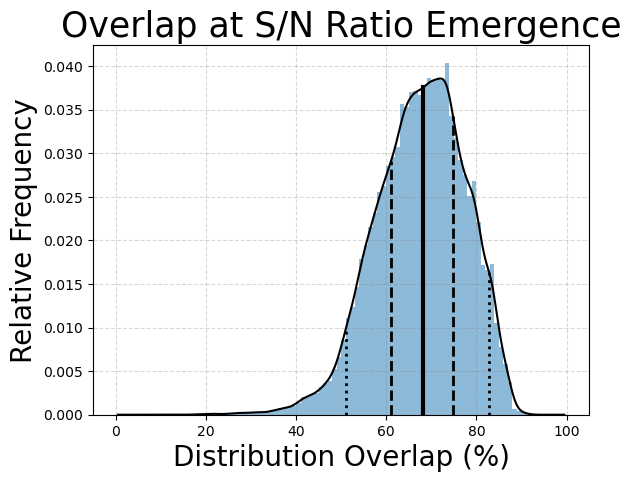

In [245]:
bins = np.arange(0, 101, 1)
fig, ax = calculate_and_plot_histogram(overlap_at_sn_lowess_emergence_ds.values, bins, 
                           title='Overlap at S/N Ratio Emergence', xlabel='Distribution Overlap (%)')

{0.05: 30.62, 0.25: 52.85, 0.5: 65.44, 0.75: 76.18, 0.95: 86.19}


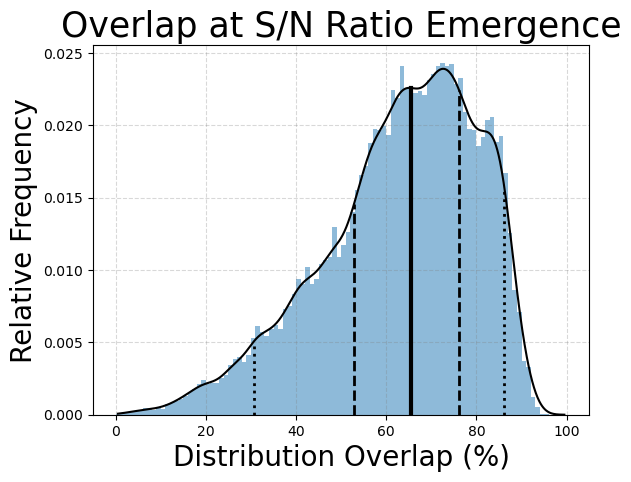

In [246]:
bins = np.arange(0, 101, 1)
fig, ax = calculate_and_plot_histogram(overlap_at_sn_emergence_ds.values, bins, 
                           title='Overlap at S/N Ratio Emergence', xlabel='Distribution Overlap (%)')

{0.05: 59.35, 0.25: 63.07, 0.5: 65.32, 0.75: 67.52, 0.95: 70.94}


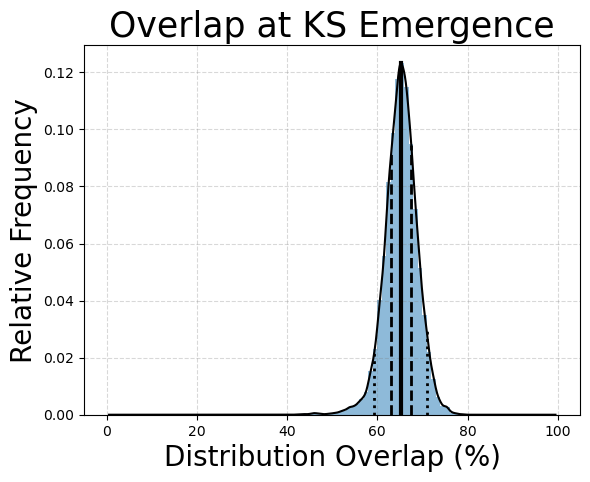

In [247]:
overlap_ks_bins = np.arange(0, 101, 1)
fig, ax = calculate_and_plot_histogram(overlap_at_ks_emergence_ds.values, overlap_ks_bins, 
                           title='Overlap at KS Emergence', xlabel='Distribution Overlap (%)')

{0.05: 0.76, 0.25: 1.07, 0.5: 1.29, 0.75: 1.46, 0.95: 1.72}


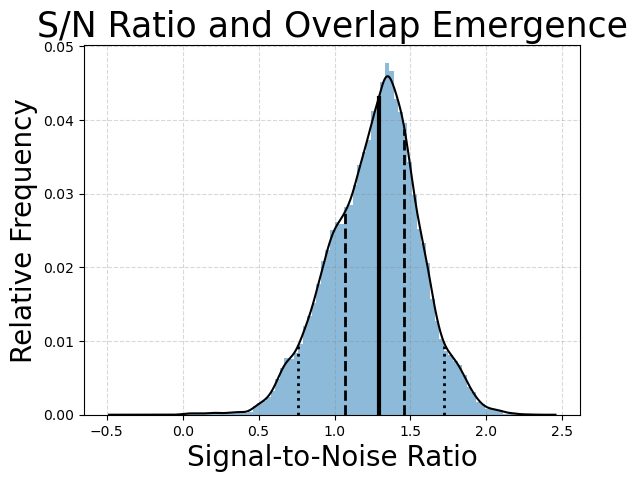

In [248]:
snr_bins = np.arange(-0.5, 2.5, .03)
fig, ax = calculate_and_plot_histogram(np.abs(sn_lowess_at_overlap_emergence_ds.values), snr_bins, 
                           title='S/N Ratio and Overlap Emergence', xlabel='Signal-to-Noise Ratio')

{0.05: 0.37, 0.25: 0.78, 0.5: 1.14, 0.75: 1.47, 0.95: 1.75}


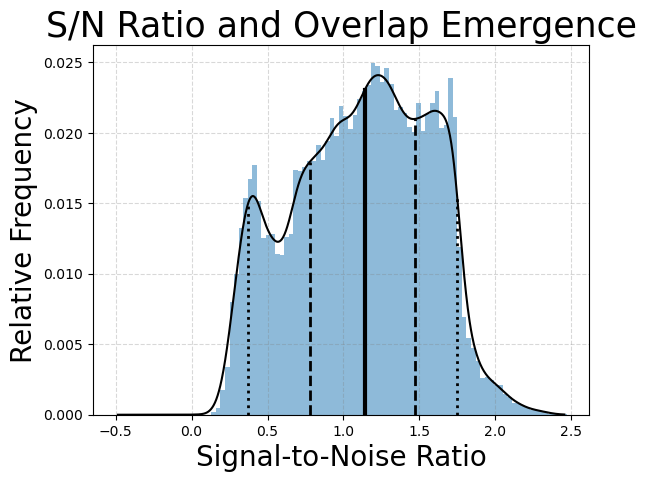

In [249]:
snr_bins = np.arange(-0.5, 2.5, .03)
fig, ax = calculate_and_plot_histogram(np.abs(sn_at_overlap_emergence_ds.values), snr_bins, 
                           title='S/N Ratio and Overlap Emergence', xlabel='Signal-to-Noise Ratio')

{0.05: 0.41, 0.25: 0.69, 0.5: 1.0, 0.75: 1.32, 0.95: 1.67}


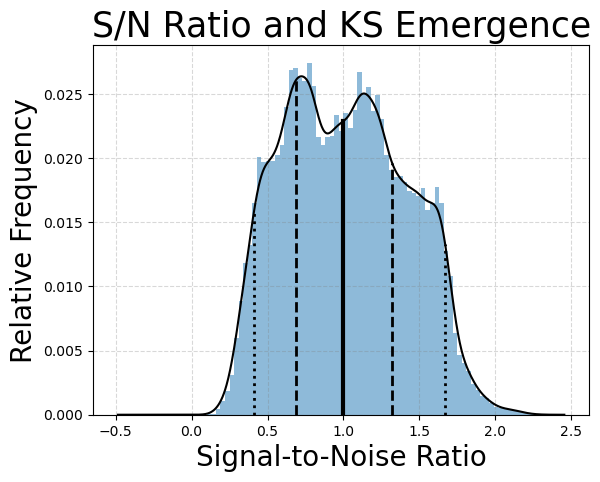

In [250]:
snr_bins = np.arange(-0.5, 2.5, .03)
fig, ax = calculate_and_plot_histogram(np.abs(sn_at_ks_emergence_ds.values), snr_bins, 
                           title='S/N Ratio and KS Emergence', xlabel='Signal-to-Noise Ratio')

In [251]:
not_stable_kwargs3 = {'cmap':cmap_binary, 'add_colorbar':False}

In [252]:
min_lat_lon_sn_at_kas =\
    utils.find_nth_extreme_location(sn_at_ks_emergence_ds, 'min',output_dtype='dict')
min_lat_lon_sn_at_kas

{'lat': 73.5, 'lon': 109.5}

In [253]:
max_lat_lon_sn_at_kas =\
    utils.find_nth_extreme_location(sn_at_ks_emergence_ds, 'max',output_dtype='dict')
max_lat_lon_sn_at_kas

{'lat': 35.5, 'lon': 102.5}

AttributeError: 'numpy.datetime64' object has no attribute 'year'

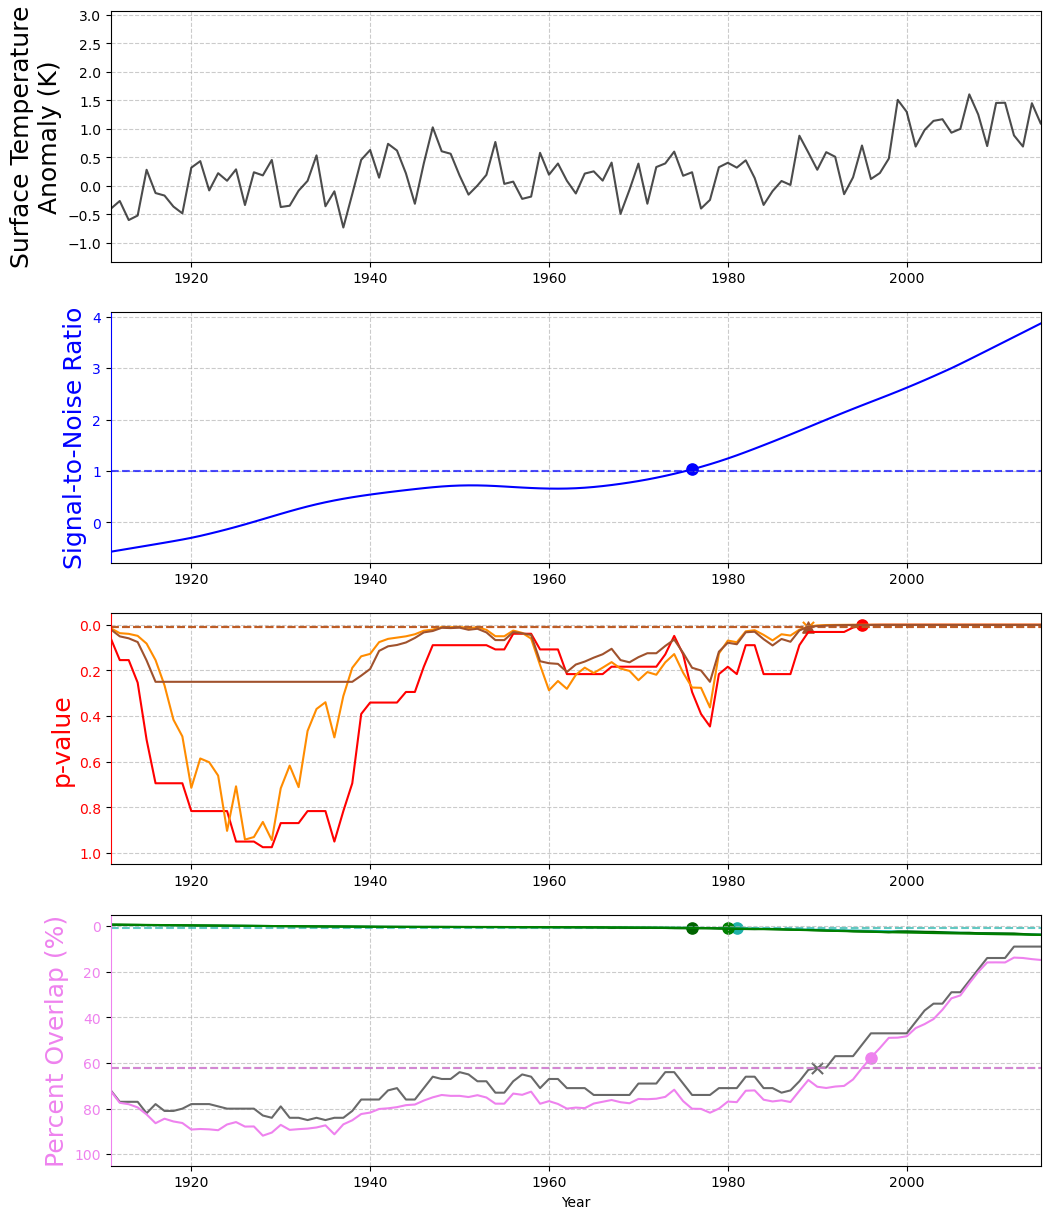

In [254]:
fig, gs, axes = time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'),
                              toe_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'),
                              data_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'), return_figure=True)
axes[0].set_title(max_lat_lon_sn_at_kas);

In [265]:
# Veriftying for a single point
signal_sp2, noise_series_sp2, reocnstructed_sp2 =\
    toe.return_hawkins_signal_and_noise(
        data_ds.sel(max_lat_lon_sn_at_kas, method='nearest').values,
         gt=data_ds_smean_lowess.values,
        return_reconstruction=True)

NameError: name 'data_ds_smean_lowess' is not defined

In [266]:
plt.plot(reocnstructed_sp2, label='reconstructed')
plt.plot(data_ds.sel(max_lat_lon_sn_at_kas, method='nearest').values, label='original')
plt.plot(signal_sp2, label='signal')
plt.plot(signal_sp2/np.nanstd(noise_series_sp2), label='signal-to-noise ratio')
plt.legend()

NameError: name 'reocnstructed_sp2' is not defined

In [267]:
# Load in the custome levels and cmaps that I have made for these plots
# levels_sn, cmap_sn = time_of_emergence_plots.generate_sn_colormap_and_levels()
# levels_overlap, cmap_overlap = time_of_emergence_plots.generate_overlap_colormap_and_levels()
levels_overlap = np.arange(16, 100, 4)
cmap_overlap = 'RdYlBu_r'

levels_sn = np.arange(-3, 3+1/3, 1/3).round(1)
cmap_sn = cmap_overlap

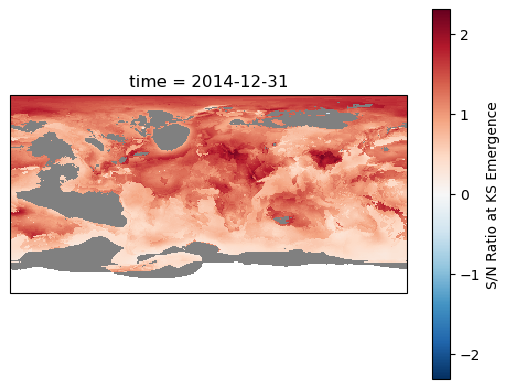

In [268]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
sn_at_ks_emergence_ds.plot(ax=ax)
# ax.contourf(
#         sn_at_ks_emergence_ds.lon, sn_at_ks_emergence_ds.lat, sn_at_ks_emergence_ds.values, 
#     cmap=cmap_sn, levels=levels_sn, extend='both'
#     )

time_of_emergence_plots.plot_condition(does_not_emerge_ds, ax, 'sn', 'ks', **not_stable_kwargs3)


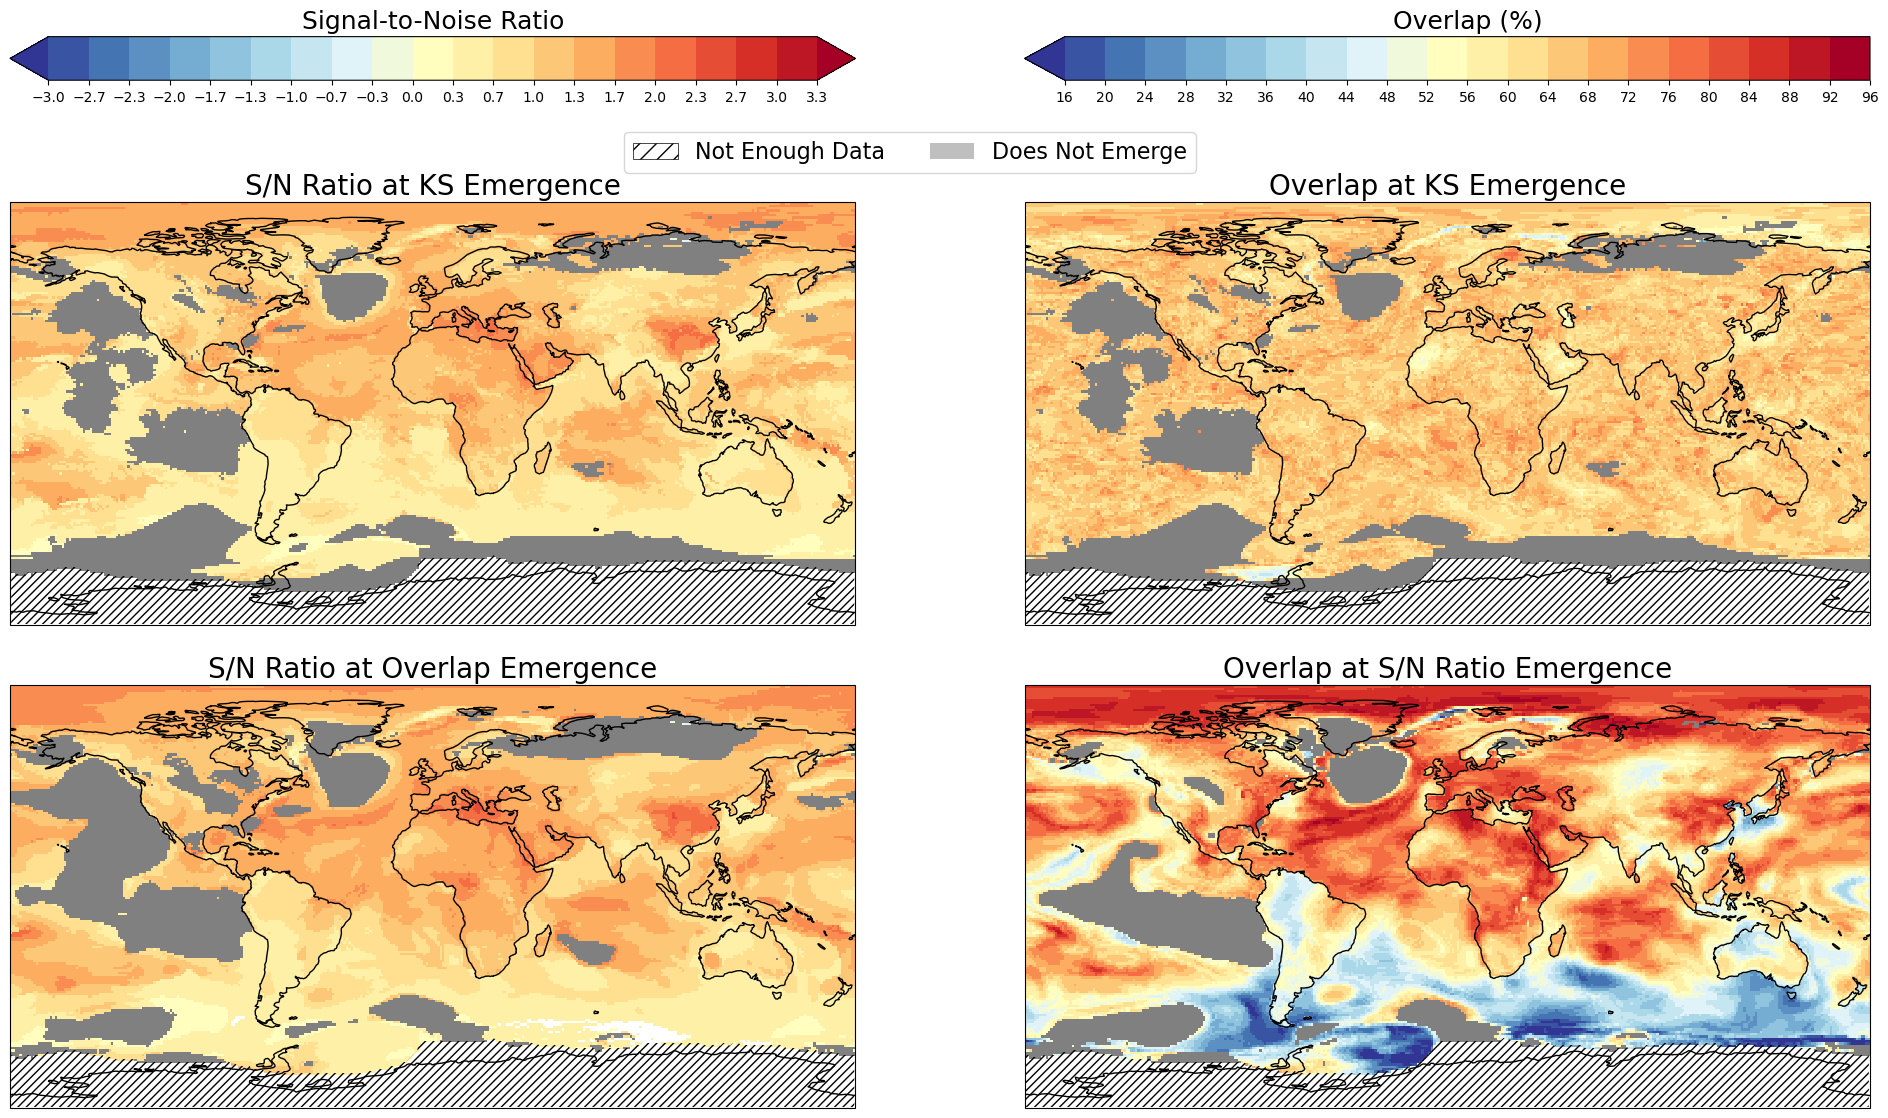

In [269]:
fig = plt.figure(figsize=(24, 14))
gs = gridspec.GridSpec(4, 2, height_ratios=[0.1, 0.05, 1, 1])

projection = ccrs.PlateCarree(central_longitude=np.mean(sn_at_ks_emergence_ds.lat.values))
axes_right = [
    fig.add_subplot(gs[i+2, 1], projection=projection) 
    for i in range(2)]
axes_left = [
    fig.add_subplot(gs[i+2, 0], projection=projection) 
    for i in range(2)]

#### Not enough data points
# Note: this comes first so it does not mess with my titles
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_right[0], 'frac', 'ks', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_right[1], 'frac', 'sn', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[0], 'sn', 'ks', **not_stable_kwargs3)
time_of_emergence_plots.plot_condition(does_not_emerge_ds, axes_left[1], 'frac', 'sn', **not_stable_kwargs3)

#### LEFT AXIS

for num, ds in enumerate([sn_at_ks_emergence_ds, sn_at_overlap_emergence_ds]):
    ax = axes_left[num]
    # toe_plot_left = ax.contourf(
    #     ds.lon, ds.lat, ds.values,
    toe_plot_left = ds.plot(ax=ax,
        cmap=cmap_sn, levels=levels_sn, extend='both', add_colorbar=False,
    )
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    ax.coastlines()
    ax.set_title(ds.long_name, fontsize=20)

cbar_axes_left = plt.subplot(gs[0, 0])
cbar_left = plt.colorbar(toe_plot_left, cax=cbar_axes_left, orientation='horizontal')
cbar_left.ax.set_title('Signal-to-Noise Ratio', fontsize=18)
cbar_left.ax.set_xticks(levels_sn)

### RIGHT AXIS


for num, ds in enumerate([overlap_at_ks_emergence_ds, overlap_at_sn_emergence_ds]):
    ax = axes_right[num]
    # toe_plot_right = ax.contourf(
    #     ds.lon, ds.lat, ds.values, 
    toe_plot_right = ds.plot(ax=ax,
        cmap=cmap_overlap, levels=levels_overlap, extend='min', add_colorbar=False
    )
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    ax.coastlines()
    ax.set_title(ds.long_name, fontsize=20)

cbar_axes_right = plt.subplot(gs[0, 1])
cbar_right = plt.colorbar(toe_plot_right, cax=cbar_axes_right, orientation='horizontal')
cbar_right.ax.set_title('Overlap (%)', fontsize=18)
cbar_right.ax.set_xticks(levels_overlap)


# Create the legend between the two colorbars
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']

fig.legend(
    legend_elements, legend_labels, loc='upper center', 
    bbox_to_anchor=(0.5, 0.82), fontsize=16, ncol=2
)


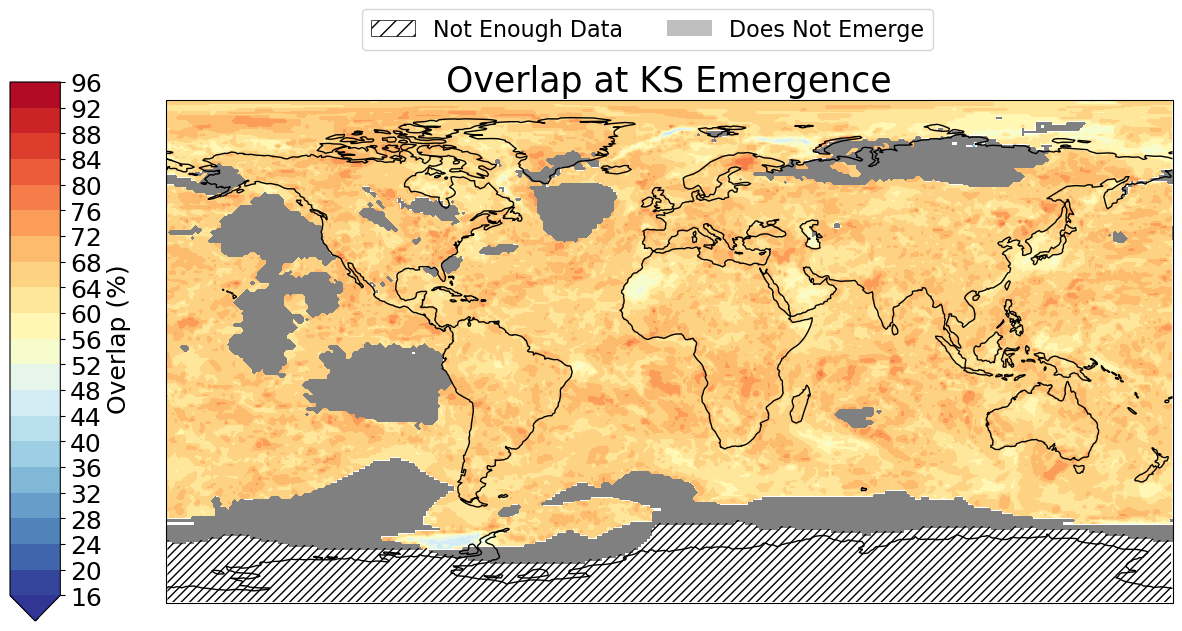

In [270]:
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2,  width_ratios=[0.05, 1], wspace=0.2)

ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())


time_of_emergence_plots.plot_condition(does_not_emerge_ds, ax, 'frac', 'ks', **not_stable_kwargs3)


ds = overlap_at_ks_emergence_ds
toe_plot_right = ax.contourf(
        ds.lon, ds.lat, ds.values, cmap=cmap_overlap, 
        levels=levels_overlap, extend='min'
    )
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
ax.coastlines()
ax.set_title(ds.long_name, fontsize=25)

cbar_axes_left2 = plt.subplot(gs[0])
cbar_right = plt.colorbar(toe_plot_right, cax=cbar_axes_left2, orientation='vertical')
cbar_right.ax.set_ylabel('Overlap (%)', fontsize=18)
cbar_right.ax.set_yticks(levels_overlap)
cbar_right.ax.tick_params(labelsize=18)


# Create the legend between the two colorbars
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']

fig.legend(
    legend_elements, legend_labels, loc='upper center', 
    bbox_to_anchor=(0.55, 1), fontsize=16, ncol=2
)

Text(0.5, 1.0, '')

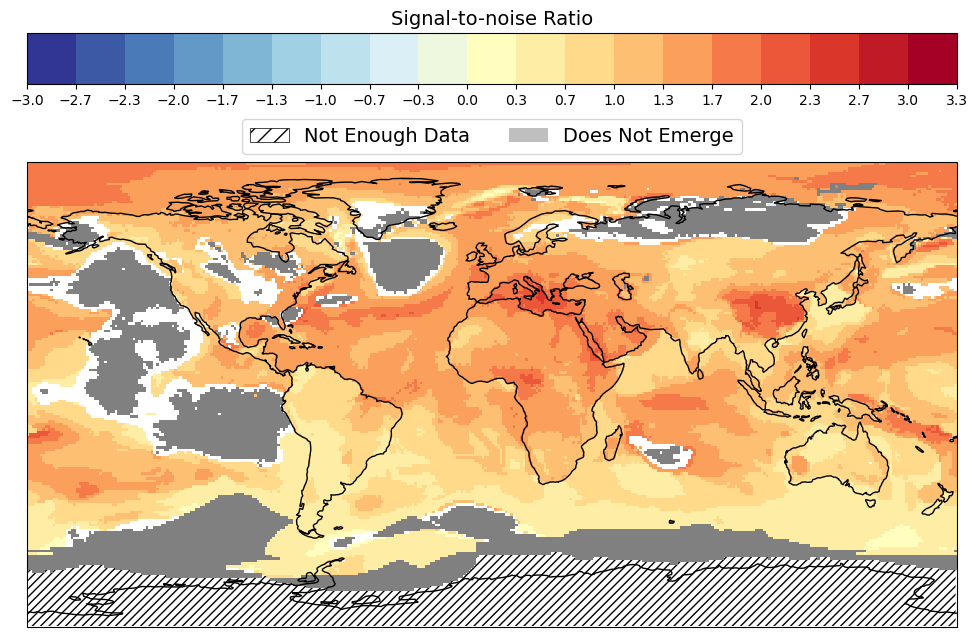

In [271]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.1, 1])
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

toe_plot = sn_at_overlap_emergence_ds.plot(ax=ax, robust=True, cmap=cmap_sn, 
                                      add_colorbar=False, levels=levels_sn)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
does_not_emerge_ds['ks'].plot(**not_stable_kwargs3)

cbar_axes1 = plt.subplot(gs[0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Signal-to-noise Ratio', fontsize=14)
cbar1.ax.set_xticks(levels_sn)
# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.5), fontsize=14, ncol=2)
ax.coastlines()
ax.set_title('')

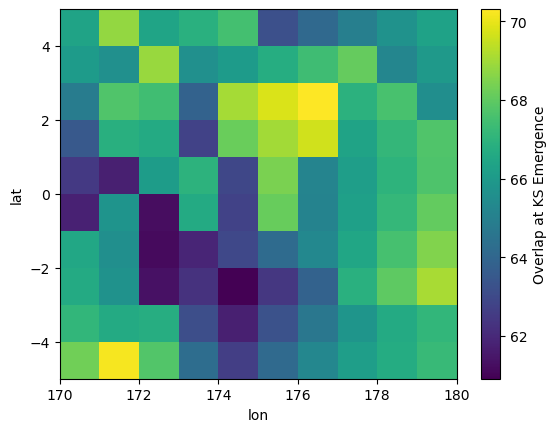

In [272]:
overlap_at_ks_emergence_ds.sel(lat=slice(-5, 5), lon=slice(170, 190)).plot()

In [273]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# overlap_at_sn_emergence_ds.sel(lat=slice(-90, -50), lon=slice(-90, -60)).plot(ax=ax)
# ax.coastlines()

# # Add gridlines
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# # Set gridlines' linestyle and color
# gl.xlines = True
# gl.ylines = True
# gl.linestyle = '--'
# gl.color = 'gray'

In [274]:
min_overlap_kwargs = dict(lat=-59, lon=-72.5, method='nearest')

In [275]:
toe_ds.sel(**min_overlap_kwargs).to_array(name='test')

<xarray.DataArray 'test' (variable: 9)> Size: 72B
array([1989., 1944., 1943., 1942., 1943., 1945., 1956., 1963., 1958.])
Coordinates:
    lat       float32 4B -58.5
    lon       float32 4B -72.5
  * variable  (variable) object 72B 'sn' 'ks' ... 'sn_lowess_rolling_smooth'

In [276]:
overlap_at_sn_emergence_ds.sel(**min_overlap_kwargs)

<xarray.DataArray 'overlap_at_sn' ()> Size: 8B
array(16.18)
Coordinates:
    lat      float32 4B -58.5
    lon      float32 4B -72.5
Attributes: (1)

In [277]:
start_select_data = data_ds.sel(**min_overlap_kwargs).where(data_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)

In [278]:
overlap_emergence_select_data = data_ds.sel(**min_overlap_kwargs).where(data_ds.time.dt.year.isin(np.arange(1934, 1954)), drop=True)

In [279]:
sn_emergence_select_data = data_ds.sel(**min_overlap_kwargs).where(data_ds.time.dt.year.isin(np.arange(1979, 1999)), drop=True)

In [280]:
toe_metrics_ds.sel(**min_overlap_kwargs)['sn'].sel(time=toe_metrics_ds.time.dt.year==1944).values

array([0.34])

In [281]:
toe.farctional_geometric_area(start_select_data.values, overlap_emergence_select_data.values)

62.13161499088523

In [282]:
toe.farctional_geometric_area(start_select_data.values, sn_emergence_select_data.values)

16.181479532704873

In [283]:
np.mean(sn_emergence_select_data).values

array(0.98, dtype=float32)

In [284]:
def generate_kde2(arr: np.ndarray, vmin, vmax) -> tuple[gaussian_kde, np.ndarray]:
    """
    Generate a kernel density estimate (KDE) from the input array.

    Parameters:
    arr (np.ndarray): The input array to generate the KDE from.
    hist_norm (float): The histogram normalization factor.
    bin_edges (np.ndarray): The bin edges for the histogram.

    Returns:
    tuple[gaussian_kde, np.ndarray]: A tuple containing the KDE generator and the normalized KDE values.
    """
    # Generate the KDE
    arr = arr[np.isfinite(arr)]
    kde_generator = gaussian_kde(arr)
    
    # Generate a grid of x values for the KDE
    x_grid = np.linspace(vmin, vmax, 1000)
    
    # Evaluate the KDE at the x grid points
    kde_values = kde_generator(x_grid)
    
    return x_grid, kde_values

In [285]:
x_grid, start_select_kde = generate_kde2(start_select_data.values, vmin=-1, vmax=2)
x_grid, sn_emergence_select_kde = generate_kde2(sn_emergence_select_data.values, vmin=-1, vmax=2)
x_grid, overlap_emergence_select_kde = generate_kde2(overlap_emergence_select_data.values, vmin=-1, vmax=2)

In [286]:
np.mean(overlap_emergence_select_data.values)

0.41151762

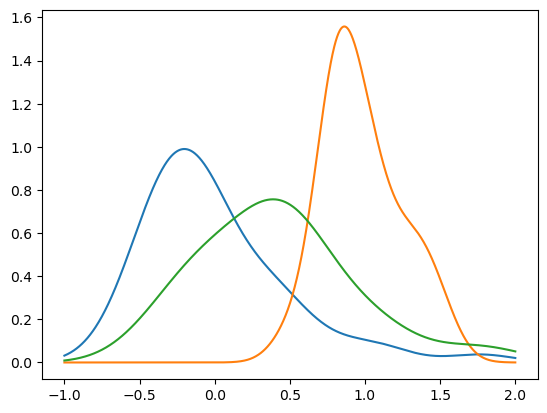

In [287]:
plt.plot(x_grid, start_select_kde)
plt.plot(x_grid, sn_emergence_select_kde)
plt.plot(x_grid, overlap_emergence_select_kde)

(array([0.51, 0.  , 2.57, 2.06, 1.03, 1.54, 0.51, 0.51, 0.51, 1.03]),
 array([0.53, 0.62, 0.72, 0.82, 0.92, 1.01, 1.11, 1.21, 1.3 , 1.4 , 1.5 ]),
 <BarContainer object of 10 artists>)

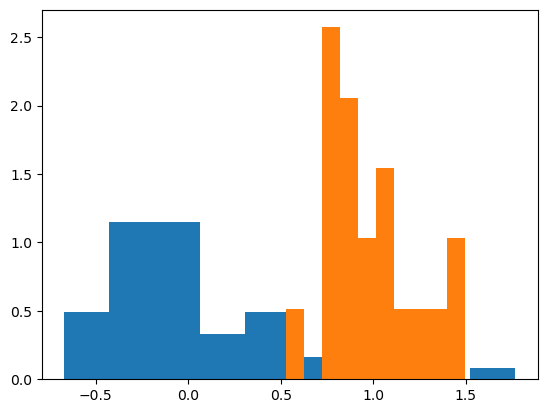

In [288]:
plt.hist(start_select_data.values, density=True)
plt.hist(sn_emergence_select_data.values, density=True)

(array([3., 3., 1., 6., 3., 1., 1., 1., 0., 1.]),
 array([-0.36, -0.15,  0.07,  0.28,  0.49,  0.7 ,  0.92,  1.13,  1.34,
         1.56,  1.77]),
 <BarContainer object of 10 artists>)

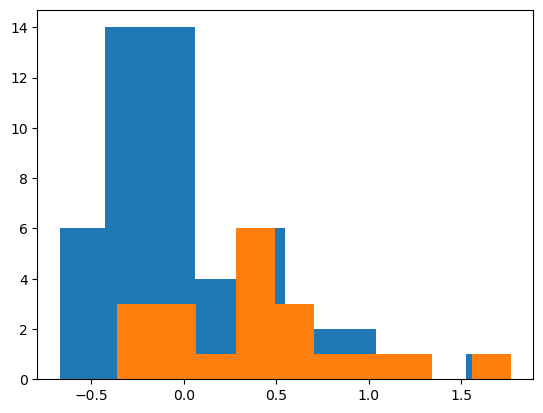

In [289]:
plt.hist(start_select_data.values)
plt.hist(overlap_emergence_select_data.values)

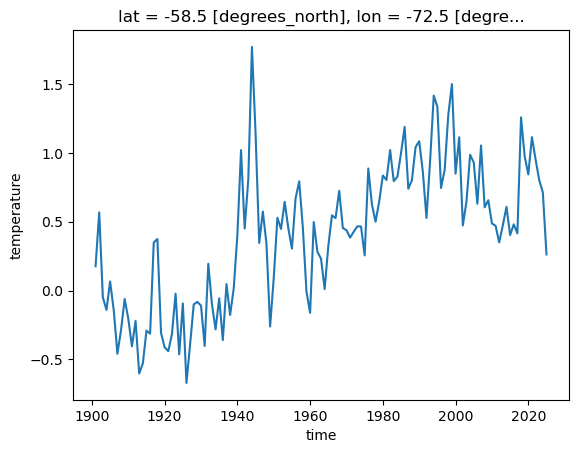

In [290]:
data_ds.sel(**min_overlap_kwargs).plot()

### Lowess vs. Signal Correlations

In [291]:
# toe_metrics_ds['sn']

In [295]:
signal_data_corr_ds = xr.corr(signal_ds['signal'], data_ds, dim='time') 

In [296]:
signal_version_corr_ds = xr.corr(signal_ds['signal'], signal_ds['signal_lowess'], dim='time') 

In [297]:
bad_sn_version_corr = signal_version_corr_ds.where(signal_version_corr_ds < 0.9, np.nan)#.plot()

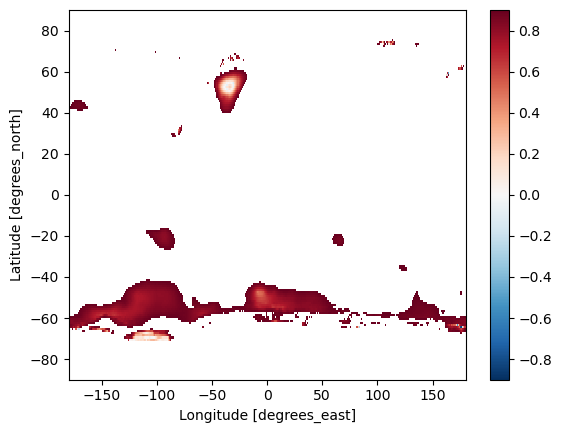

In [298]:
bad_sn_version_corr.plot()

<xarray.Dataset> Size: 490MB
Dimensions:                   (lat: 180, lon: 360, time: 105)
Coordinates:
  * lat                       (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                       (lon) float32 1kB -179.5 -178.5 ... 178.5 179.5
  * time                      (time) datetime64[ns] 840B 1910-12-31 ... 2014-...
Data variables:
    sn                        (lat, lon, time) float64 54MB nan nan ... 2.34
    ks                        (time, lat, lon) float64 54MB nan nan ... 1.82e-11
    ttest                     (time, lat, lon) float64 54MB nan ... 3.238e-15
    anderson                  (time, lat, lon) float64 54MB nan nan ... 0.001
    perkins                   (time, lat, lon) float64 54MB nan nan ... 8.0 8.0
    frac                      (time, lat, lon) float64 54MB nan nan ... 21.11
    sn_lowess                 (lat, lon, time) float64 54MB nan nan ... 2.278
    sn_lowess_rolling         (lat, lon, time) float64 54MB nan nan ... 1.944
    sn_lowess_rolling_smooth  (lat, lon, time) float64 54MB nan nan ... 2.583
Attributes: (1)

In [316]:
difference_sn_ks_ds = toe_metrics_ds['sn'] - toe_metrics_ds['ks']

In [351]:
# plt.scatter(difference_sn_ks_ds.values.flatten(),
#           signal_version_corr_ds.values.flatten() )

(array([0.01, 0.3 , 0.37, 0.23, 0.12, 0.05, 0.01, 0.  , 0.  , 0.  ]),
 array([-2.19, -1.28, -0.36,  0.56,  1.48,  2.39,  3.31,  4.23,  5.14,
         6.06,  6.98]),
 <BarContainer object of 10 artists>)

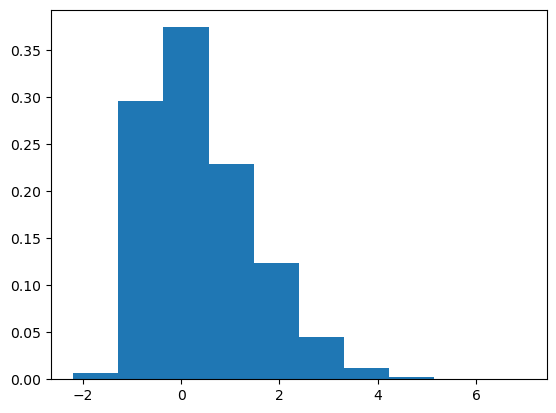

In [319]:
plt.hist(difference_sn_ks_ds.values.flatten(), density=True)

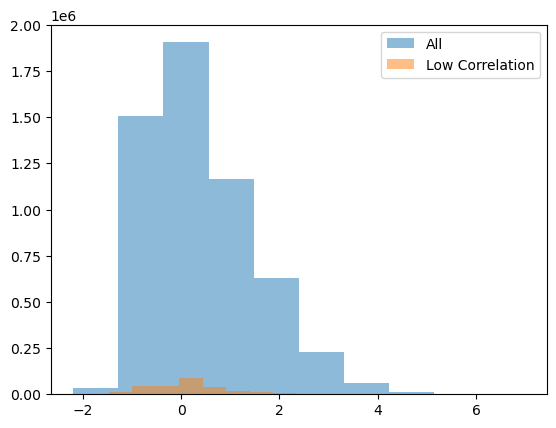

In [320]:
plt.hist(difference_sn_ks_ds.values.flatten(), label='All', alpha=0.5)
plt.hist(difference_sn_ks_ds.where(np.isfinite(bad_sn_version_corr)).values.flatten(), 
         label='Low Correlation', alpha=0.5)
plt.legend()

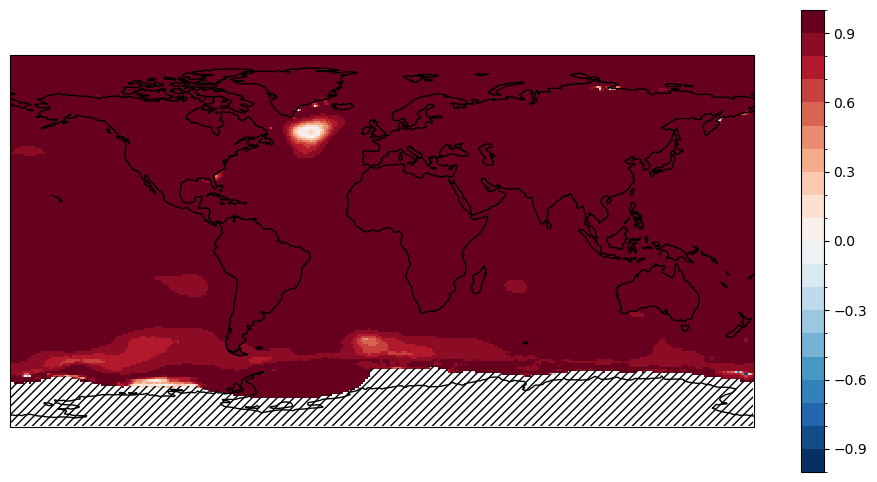

In [321]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
signal_version_corr_ds.plot(ax=ax, levels=np.arange(-1, 1.1, 0.1))
ax.coastlines()
hatch(ax, data_unavailability_mask, **not_stable_kwargs)

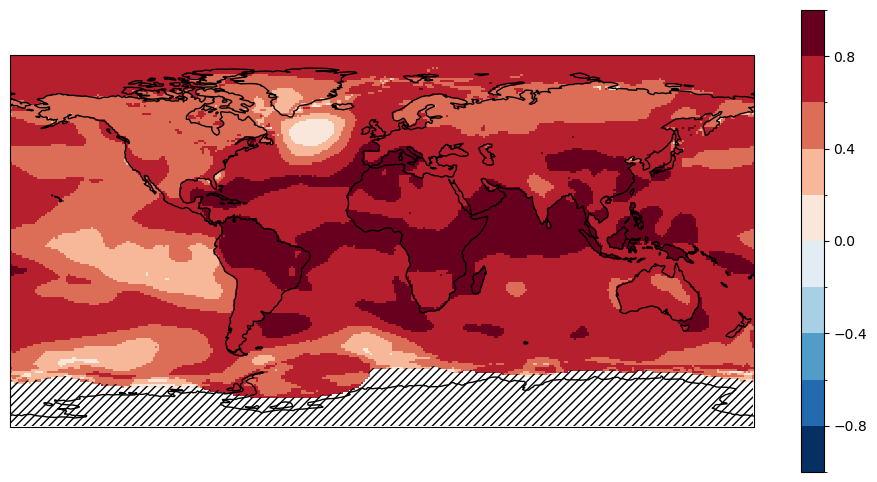

In [306]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
signal_data_corr_ds.plot(ax=ax, levels=np.arange(-1, 1.2, 0.2))
ax.coastlines()
hatch(ax, data_unavailability_mask, **not_stable_kwargs)

In [322]:
corr_flat = signal_data_corr_ds.values.flatten()
difference_sn_ks_flat = difference_sn_ks_ds.values.flatten()

In [323]:
print(signal_data_corr_ds.stack(latlon=['lat', 'lon']).drop('lat'))

<xarray.DataArray (latlon: 64800)> Size: 518kB
array([ nan, ..., 0.67])
Dimensions without coordinates: latlon


In [355]:
def sort_correlation(ds):
    # This is a better way of getting all the smallest and largest locations of correlations
    ds_stacked = ds.stack(latlon=['lat', 'lon'])
    ds_stacked = ds_stacked.dropna(dim='latlon')
    ds_stacked.name = 'correlation'
    
    correlation_df = ds_stacked.to_dataframe(name='correlation')#.reset_index()
    correlation_df = pd.DataFrame({'latlon':list(zip(correlation_df['lat'].values, correlation_df['lon'].values)), 
                                   'correlation': correlation_df['correlation'].values}).set_index('latlon')
    correlation_df = correlation_df.sort_values('correlation')
    return correlation_df

In [ ]:
signal_version_corr_ds

In [357]:
signal_correlation_df = sort_correlation(signal_version_corr_ds)
signal_correlation_df.head()

correlation
latlon                     
(-64.5, 176.5)    -0.847679
(-64.5, 175.5)    -0.820844
(-63.5, 172.5)    -0.547280
(59.5, 164.5)     -0.502951
(-64.5, 83.5)     -0.280200

In [356]:
correlation_df = sort_correlation(signal_data_corr_ds)
correlation_df.head()

correlation
latlon                    
(51.5, -31.5)     0.001173
(51.5, -35.5)     0.001539
(53.5, -36.5)     0.001798
(54.5, -30.5)     0.002094
(53.5, -29.5)     0.003380

In [324]:
# # This is a better way of getting all the smallest and largest locations of correlations
# signal_data_corr_ds_stacked = signal_data_corr_ds.stack(latlon=['lat', 'lon'])
# signal_data_corr_ds_stacked = signal_data_corr_ds_stacked.dropna(dim='latlon')
# signal_data_corr_ds_stacked.name = 'correlation'

# correlation_df = signal_data_corr_ds_stacked.to_dataframe(name='correlation')#.reset_index()
# correlation_df = pd.DataFrame({'latlon':list(zip(correlation_df['lat'].values, correlation_df['lon'].values)), 
#                                'correlation': correlation_df['correlation'].values}).set_index('latlon')
# correlation_df = correlation_df.sort_values('correlation')
# correlation_df.head()

correlation
latlon                    
(51.5, -31.5)     0.001173
(51.5, -35.5)     0.001539
(53.5, -36.5)     0.001798
(54.5, -30.5)     0.002094
(53.5, -29.5)     0.003380

In [325]:
signal_ds

<xarray.Dataset> Size: 259MB
Dimensions:               (lat: 180, lon: 360, time: 125)
Coordinates:
  * lat                   (lat) float32 720B -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                   (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time                  (time) datetime64[ns] 1kB 1900-12-31 ... 2024-12-31
Data variables:
    signal                (lat, lon, time) float64 65MB ...
    signal_lowess         (lat, lon, time) float64 65MB ...
    noise_lowess          (time, lat, lon) float64 65MB ...
    noise_lowess_rolling  (time, lat, lon) float64 65MB nan nan ... 0.8109

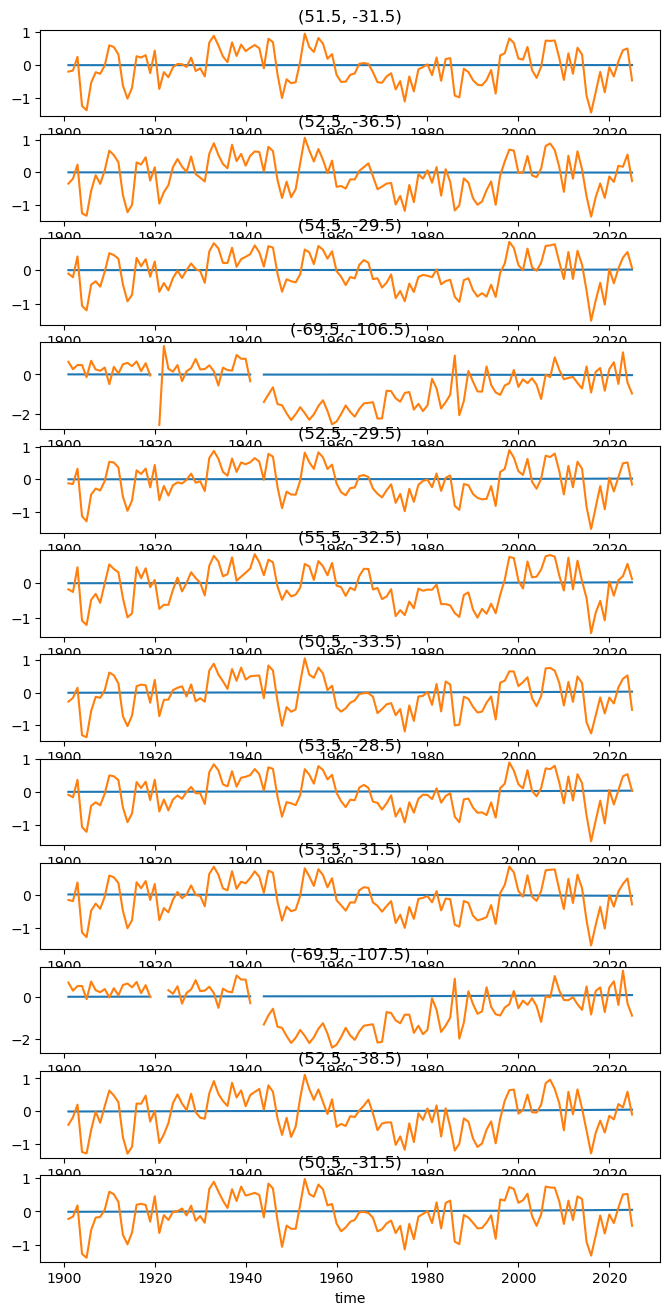

In [326]:
smallest_correlations = correlation_df.iloc[0:60:5, :]

fig = plt.figure(figsize=(8, 16))
axes = [fig.add_subplot( len(smallest_correlations), 1, i+1) for i in range(len(smallest_correlations))]

for num, latlon in enumerate(smallest_correlations.index.values):
    ax = axes[num]
    # subset_ds = data_ds.sel(lat=latlon[0], lon=latlon[1])
    signal_ds['signal'].sel(lat=latlon[0], lon=latlon[1]).plot(ax=ax)
    data_ds.sel(lat=latlon[0], lon=latlon[1]).plot(ax=ax)
    ax.set_title(latlon)
    ax.set_ylabel('')
    # ax.tick_params(axis='x', fontsize=10)

In [366]:
# total_lat_lon_max =\
#     utils.find_nth_extreme_location(
#         difference_sn_ks_ds, 'max',
#     output_dtype='dict')
# total_lat_lon_max

In [373]:
total_lat_lon_max = dict(zip(('lat', 'lon') ,correlation_df.index.values[30]))
total_lat_lon_max

{'lat': 50.5, 'lon': -33.5}

In [368]:
def format_lat_lon_title(location):
    lat = location['lat']
    lon = location['lon']
    
    lat_direction = 'N' if lat >= 0 else 'S'
    lon_direction = 'E' if lon >= 0 else 'W'
    
    lat_str = f"{abs(lat)}° {lat_direction}"
    lon_str = f"{abs(lon)}° {lon_direction}"
    
    return f"{lat_str}, {lon_str}"

Text(0.5, 1.0, 'Noise Difference')

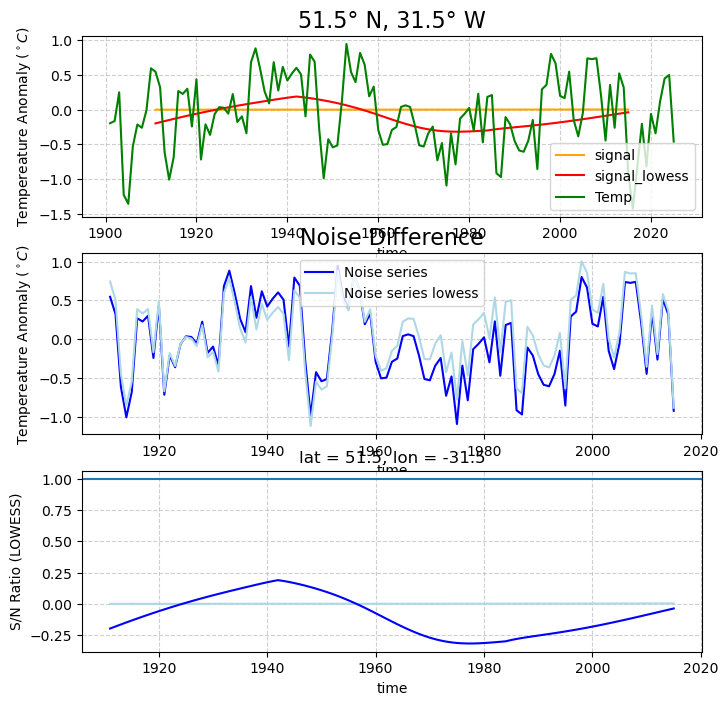

In [369]:

fig, axes = plt.subplots(3, 1, figsize=(8, 8))


(ax1, ax2, ax3) = axes
# ax2 = ax1#.twinx()
toe_metrics_ds['sn'].sel(**total_lat_lon_max).plot(ax=ax1, label='signal', color='orange')
toe_metrics_ds['sn_lowess'].sel(**total_lat_lon_max).plot(ax=ax1, label='signal_lowess', color='red')

data_ds.sel(**total_lat_lon_max).plot(ax=ax1, label='Temp', color='green')
(data_ds-toe_metrics_ds['sn']).sel(**total_lat_lon_max).plot(ax=ax2, color='blue', label='Noise series')

(data_ds-toe_metrics_ds['sn_lowess']).sel(**total_lat_lon_max).plot(ax=ax2, color='lightblue', label='Noise series lowess')

toe_metrics_ds['sn'].sel(**total_lat_lon_max).plot(ax=ax3, color='lightblue', label='Hawkins')
toe_metrics_ds['sn_lowess'].sel(**total_lat_lon_max).plot(ax=ax3, color='blue', label='lowess')
ax3.axhline(1)

ax1.legend()
ax2.legend(loc='upper center')


[ax.grid(True, linestyle='--', alpha=0.6) for ax in axes]

ax1.set_ylabel('Tempereature Anomaly ('+r'$^\circ C$)' )
ax2.set_ylabel('Tempereature Anomaly ('+r'$^\circ C$)' )

ax1.set_title(format_lat_lon_title(total_lat_lon_max), fontsize=16)

ax2.set_title('Noise Difference', fontsize=16)

In [370]:
def calculate_residuals(ds, ds_smooth, loc):
    ds = ds.where(ds.time.isin(ds_smooth.time.values), drop=True)
    original_arr = ds.sel(**loc).values
    # lowess_arr = toe_metrics_ds['sn_lowess'].sel(**total_lat_lon_max).values
    lowess_arr = ds_smooth.sel(**loc).values
    # Calculate residuals
    residuals = original_arr - lowess_arr

    return original_arr, residuals

In [371]:
data_ds

<xarray.DataArray 'temperature' (time: 125, lat: 180, lon: 360)> Size: 32MB
array([[[ nan, ...,  nan],
        ...,
        [0.1 , ..., 0.1 ]],

       ...,

       [[ nan, ...,  nan],
        ...,
        [2.13, ..., 2.12]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 1kB 1900-12-31 1901-12-31 ... 2024-12-31

In [335]:
toe_metrics_ds['sn']

<xarray.DataArray 'sn' (lat: 180, lon: 360, time: 105)> Size: 54MB
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[-0.352247, -0.334286, ...,  2.335472,  2.38976 ],
        [-0.35242 , -0.33445 , ...,  2.336618,  2.390932],
        ...,
        [-0.351607, -0.333679, ...,  2.331232,  2.385422],
        [-0.351831, -0.333892, ...,  2.332714,  2.386938]],

       [[-0.344973, -0.327383, ...,  2.287245,  2.340412],
        [-0.344447, -0.326884, ...,  2.283758,  2.336844],
        ...,
        [-0.344803, -0.327222, ...,  2.28612 ,  2.339261],
        [-0.344966, -0.327377, ...,  2.287198,  2.340364]]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) datetime64[ns] 840B 1910-12-31 1911-12-31 ... 2014-12-31
Attributes: (1)

In [336]:
original_arr,residuals_hawkins = calculate_residuals(data_ds, toe_metrics_ds['sn'], total_lat_lon_max)
original_arr,residuals_lowess = calculate_residuals(data_ds, toe_metrics_ds['sn_lowess'], total_lat_lon_max)

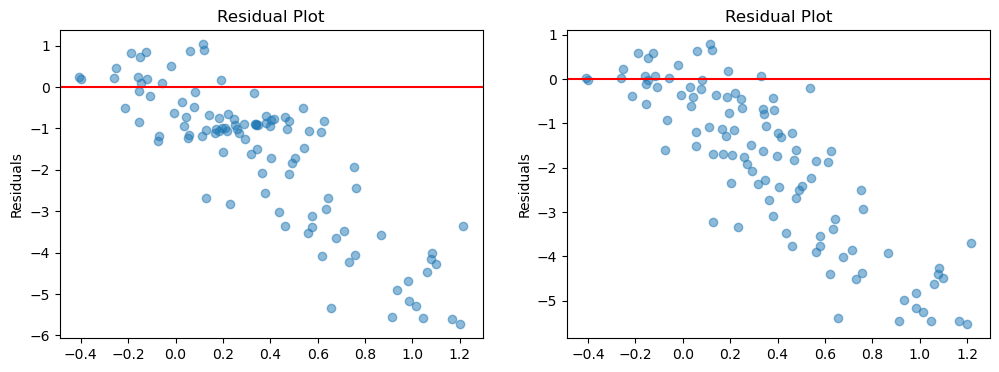

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


axes[0].scatter(original_arr, residuals_hawkins, alpha=0.5)  # alpha for transparency
axes[1].scatter(original_arr, residuals_lowess, alpha=0.5)  # alpha for transparency


for ax in axes:
    ax.set_label('Original Values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot')
    ax.axhline(0, color='red')

(array([ 7.,  3.,  6.,  8.,  7.,  6., 21., 27., 12.,  8.]),
 array([-5.73, -5.06, -4.38, -3.7 , -3.03, -2.35, -1.67, -1.  , -0.32,
         0.36,  1.03]),
 <BarContainer object of 10 artists>)

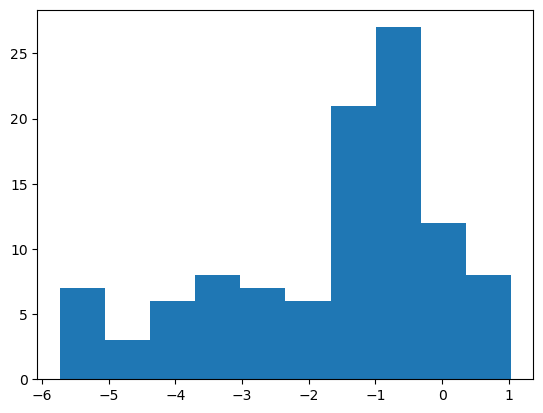

In [338]:
plt.hist(residuals_hawkins)

(array([ 8.,  8.,  7.,  7.,  8.,  9., 17., 10., 22.,  9.]),
 array([-5.53, -4.9 , -4.27, -3.64, -3.01, -2.37, -1.74, -1.11, -0.48,
         0.15,  0.79]),
 <BarContainer object of 10 artists>)

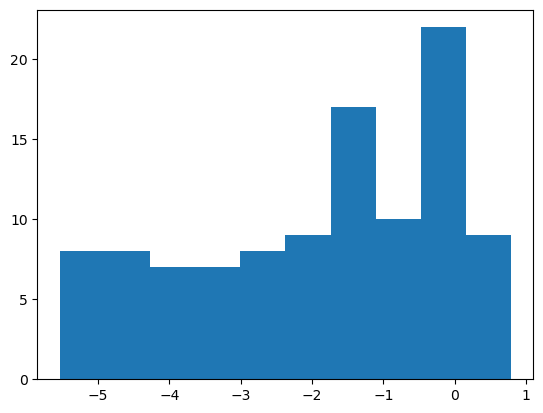

In [339]:
plt.hist(residuals_lowess)

In [340]:
from scipy.stats import shapiro

In [341]:
return_shapiro_pvalue = partial(toe.return_statistical_pvalue, stats_test=shapiro)

In [342]:
def return_shapiro_pvalue(arr):
    if np.all(np.isnan(arr)): return np.nan
    arr = arr[np.isfinite(arr)]
    return shapiro(arr).pvalue

In [ ]:
shapria_hawkins_lowess = xr.apply_ufunc(
    return_shapiro_pvalue, 
    data_ds-toe_metrics_ds['sn'],
    input_core_dims=[['time']], 
    output_core_dims=[[]], 
    vectorize=True
)

In [ ]:
shapria_hawkins_lowess.plot()

In [386]:
correlation_df.iloc[100]

correlation    0.053969
Name: (-64.5, 83.5), dtype: float64

In [396]:
total_lat_lon_max = dict(zip(('lat', 'lon') ,correlation_df.index.values[10]))
total_lat_lon_max

{'lat': 54.5, 'lon': -29.5}

In [ ]:
toe_metrics_ds['sn'].sel(**total_lat_lon_max).plot()

[None, None]

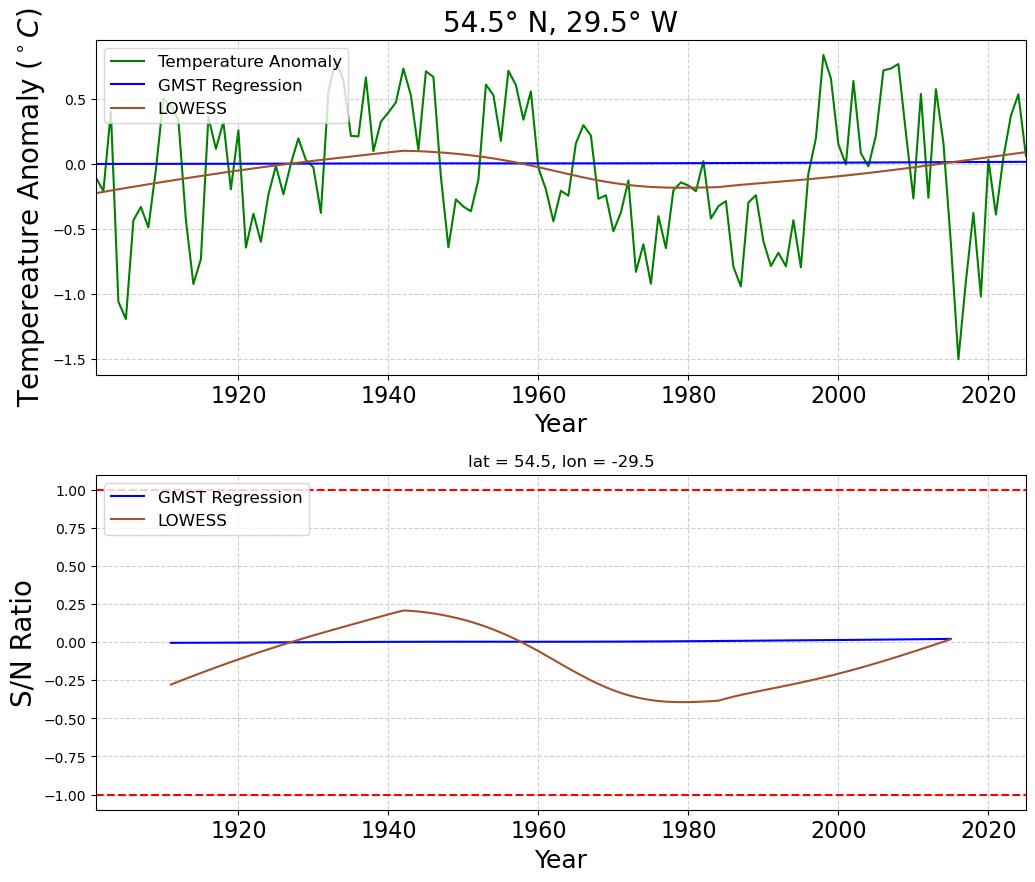

In [397]:

# fig, axes = plt.subplots(2, 1, figsize=(12, 10))
# (ax1, ax3) = axes
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, hspace=0.3)
axes = [fig.add_subplot(gs[i]) for i in range(2)]
(ax1, ax3) = axes


data_ds.sel(**total_lat_lon_max).plot(ax=ax1, label='Temperature Anomaly', color='green')

signal_ds['signal'].sel(**total_lat_lon_max).plot(ax=ax1, label='GMST Regression', color='blue')
signal_ds['signal_lowess'].sel(**total_lat_lon_max).plot(ax=ax1, label='LOWESS', color='sienna')


ax3.axhline(1, linestyle='--', color='red')
ax3.axhline(-1, linestyle='--', color='red')

toe_metrics_ds['sn'].sel(**total_lat_lon_max).plot(ax=ax3, color='blue', label='GMST Regression')
toe_metrics_ds['sn_lowess'].sel(**total_lat_lon_max).plot(ax=ax3, color='sienna', label='LOWESS')

[ax.legend(loc='upper left', fontsize=12) for ax in axes]
[ax.grid(True, linestyle='--', alpha=0.6) for ax in axes]
[ax.set_xlim(*np.take(data_ds.time.values, [0, -1])) for ax in axes]

ax1.set_ylabel('Tempereature Anomaly ('+r'$^\circ C$)', fontsize=20)
ax1.set_title(format_lat_lon_title(total_lat_lon_max), fontsize=20)
ax3.set_ylabel('S/N Ratio', fontsize=20)

ax1.set_xlabel('Year', fontsize=18)
ax3.set_xlabel('Year', fontsize=18)
[ax.tick_params(axis='x', labelsize=16) for ax in axes]

ValueError: x and y must be the same size

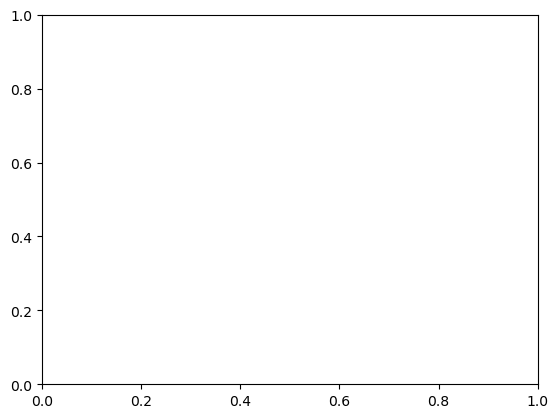

In [349]:
plt.scatter(difference_sn_ks_flat, corr_flat)

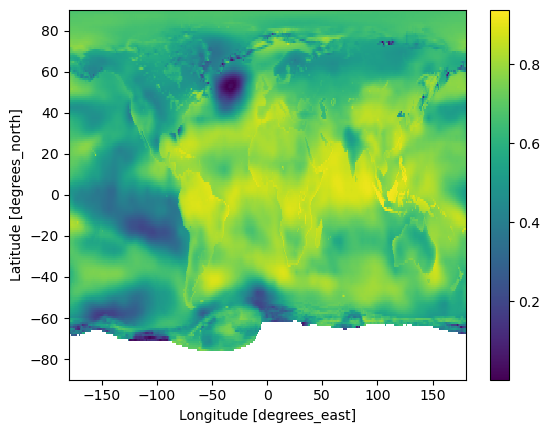

In [350]:
signal_data_corr_ds.plot()

### Explorign Odd Patterns

In [ ]:
time_indices = np.array([0, 50, 100])

In [209]:
ttest_ds = ttest_ds.sortby('lat', ascending=True)

NameError: name 'ttest_ds' is not defined

In [ ]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))


In [ ]:
min_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'min',output_dtype='dict')
min_lat_lon

In [ ]:
max_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'max',output_dtype='dict')
max_lat_lon

In [ ]:
min_time_series = data_ds.sel(**min_lat_lon)
max_time_series = data_ds.sel(**max_lat_lon)

In [ ]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [ ]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

In [ ]:
toe_const.NAME_CONVERSION_DICT

In [ ]:
long_names = list(toe_const.NAME_CONVERSION_DICT)

### Point Selection Plots

In [ ]:
data_ds

In [ ]:
total_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds, 'max',
    output_dtype='dict')

In [ ]:
total_lat_lon_max

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
toe_metrics_ds['sn'].sel(**total_lat_lon_max).plot(ax=ax1, label='signal', color='orange')
ds_data_sn.sel(**total_lat_lon_max).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**total_lat_lon_max).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series.sel(**total_lat_lon_max).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

In [ ]:
### Asia Targeting

asia_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'max',
    output_dtype='dict')

asia_lat_lon_min =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'min',
    output_dtype='dict')

asia_lat_lon_max, asia_lat_lon_min

In [ ]:
# ### North America Targeting

# na_lat_lon_max =\
#     utils.find_nth_extreme_location(
#         difference_sn_ks_ds.sel(toe_const.LocationBoxes.NORTH_AMERICA_LAND_TARGET.value), 'max',
#     output_dtype='dict')

na_lat_lon_min = {'lat': 22.5, 'lon': -94.5}
na_lat_lon_max = na_lat_lon_min
na_lat_lon_min

In [ ]:
# ds_data_noise_series.sel(**na_lat_lon_min).plot(color='blue', label='Noise series')


In [ ]:
# fig, ax1 = plt.subplots(1, 1)
# ax2 = ax1#.twinx()
# toe_metrics_ds['sn'].sel(**na_lat_lon_min).plot(ax=ax1, label='signal', color='orange')
# ds_data_sn.sel(**na_lat_lon_min).plot(ax=ax1, label='sn', color='red')

# data_ds.sel(**na_lat_lon_min).plot(ax=ax2, label='Temp', color='green')
# ds_data_noise_series.sel(**na_lat_lon_min).plot(ax=ax2, color='blue', label='Noise series')

# ax1.legend()
# ax2.legend(loc='upper center')

In [ ]:
# fig = plt.figure(figsize=(16, 14))
# gs = gridspec.GridSpec(6, 2, hspace=0, height_ratios = [1, 0.1]+ [0.2]*4) 
# ax_top = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
# axes_left = [fig.add_subplot(gs[i+2, 0]) for i in range(4)]
# axes_right = [fig.add_subplot(gs[i+2, 1]) for i in range(4)]

# time_of_emergence_plots.plot_condition(does_not_emerge_ds.sel(toe_const.LocationBoxes.ASIA.value),
#                                        ax_top, 'ks', 'sn', **not_stable_kwargs2)

# plot = difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value).plot(ax=ax_top, cmap='RdYlBu_r', vmin=-30, vmax=30, 
#                                                                         cbar_kwargs={'label':'Difference (years)'})
# # Adjust colorbar label size
# cbar = plot.colorbar
# cbar.set_label('SN - KS (years)', fontsize=14) 
# ax_top.scatter(x=asia_lat_lon_max['lon'], y=asia_lat_lon_max['lat'], marker='x', alpha=.9, s=100, color='blue')
# ax_top.scatter(x=asia_lat_lon_min['lon'], y=asia_lat_lon_min['lat'], marker='x', alpha=.9, s=100, color='gold')
# hatch(ax_top, data_unavailability_mask.sel(toe_const.LocationBoxes.ASIA.value), **not_stable_kwargs)


# plotting_utils.format_lat_lon(ax_top)
# ax_top.coastlines()


# axes_left[0].set_title('MAX:'+str(na_lat_lon_max) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_max).astype(int).values)} years)', 
#                        color='blue')
# time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_max, method='nearest'),
#                               toe_ds.sel(**asia_lat_lon_max, method='nearest'),
#                               data_ds.sel(**asia_lat_lon_max, method='nearest'), 
#                              fig=fig, gs=gs, axes=axes_left)


# axes_right[0].set_title('MIN:'+str(na_lat_lon_min) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_min).astype(int).values)} years)',
#                         color='gold')
# time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_min, method='nearest'),
#                               toe_ds.sel(**asia_lat_lon_min, method='nearest'),
#                               data_ds.sel(**asia_lat_lon_min, method='nearest'), 
#                              fig=fig, gs=gs, axes=axes_right)

# Part II: Component wise emergence

In [ ]:
from scipy.stats import cramervonmises

In [ ]:
client.cluster.scale(18)
sleep(7)

In [ ]:
toe_metrics_ds['sn_lowess']

In [ ]:
data_detrend_ds = data_ds - toe_metrics_ds['sn_lowess']

In [ ]:
data_ds.sel(lat=-39, lon=145, method='nearest').plot()
data_detrend_ds.sel(lat=-39, lon=145, method='nearest').plot()

In [ ]:
# data_detrend_rolling_std = data_detrend_ds.rolling(time=20).std(dim='time')

In [ ]:
window = 20

In [ ]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}

In [ ]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [ ]:
data_ds_detrend_window = (data_detrend_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_detrend_window_ds = (data_detrend_ds.where(data_detrend_ds.time == base_period_ds.time, drop=True)
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [ ]:
# Creting new datasets that has windown dimnsion for the rolling calculation
data_ds_window = (data_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [ ]:
# %%time
# ks_detrend_ds = xr.apply_ufunc(
#         toe.return_ks_pvalue,
#         data_ds_detrend_window,
#         base_period_detrend_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
%%time
mannwhitney_ds = xr.apply_ufunc(
        toe.return_mannwhitney_pvalue,
        data_ds_window,
        base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

In [ ]:
%%time
krukal_detrend_ds = xr.apply_ufunc(
        toe.return_levene_pvalue,
        data_ds_detrend_window,
        base_period_detrend_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
# %%time
# levene_detrend_ds = xr.apply_ufunc(
#         toe.return_levene_pvalue,
#         data_ds_detrend_window,
#         base_period_detrend_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
# %%time
# anderson_detrend_ds = xr.apply_ufunc(
#         toe.return_anderson_pvalue,
#         data_ds_detrend_window,
#         base_period_detrend_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
# ks_detrend_ds = ks_detrend_ds.isel(time=slice(int(window/2), -int(window/2)))
# anderson_detrend_ds = anderson_detrend_ds.isel(time=slice(int(window/2), -int(window/2)))
# levene_detrend_ds = levene_detrend_ds.isel(time=slice(int(window/2), -int(window/2)))
mannwhitney_ds = mannwhitney_ds.isel(time=slice(int(window/2), -int(window/2)))
krukal_detrend_ds = krukal_detrend_ds.isel(time=slice(int(window/2), -int(window/2)))

In [ ]:
mannwhitney_ds.name = 'mann'
krukal_detrend_ds.name = 'kruskal'
# anderson_detrend_ds.name = 'anderson'
# levene_detrend_ds.name = 'levene'
# ks_detrend_ds.name = 'ks'

In [ ]:
# New Component wise emergence
# ks_detrend_toe_ds = toe.get_permanent_exceedance(ks_detrend_ds, threshold=PVALUE_THESHOLD1,
#                                                     comparison_func=np.less)

# # New Component wise emergence
# levene_detrend_toe_ds = toe.get_permanent_exceedance(levene_detrend_ds, threshold=PVALUE_THESHOLD1,
#                                                     comparison_func=np.less)
mannwhitney_toe_ds = toe.get_permanent_exceedance(mannwhitney_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)

kruskal_detrend_toe_ds = toe.get_permanent_exceedance(krukal_detrend_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)

# anderson_detrend_toe_ds = toe.get_permanent_exceedance(anderson_detrend_ds, threshold=PVALUE_THESHOLD1,
#                                                     comparison_func=np.less)

In [ ]:
# toe_shape_ds = xr.merge([
#     ks_detrend_toe_ds, levene_detrend_toe_ds, mannwhitney_toe_ds, anderson_detrend_toe_ds
    
# ])
# toe_shape_ds = xr.where(toe_shape_ds<2080, toe_shape_ds, np.nan)

# shape_emerges_somehwere_ds = xr.where(np.isfinite(toe_shape_ds['ks']) + np.isfinite(toe_shape_ds['anderson']) +\
#                                       np.isfinite(toe_shape_ds['levene']) + np.isfinite(toe_shape_ds['mann'])
#                                       , 1, 0)

# toe_with_shape_emergence_ds = toe_ds['ks'].where(shape_emerges_somehwere_ds==1)
# toe_without_shape_emergenc_ds = toe_ds['ks'].where(shape_emerges_somehwere_ds==0)

In [ ]:
# 3 -  emergence of both
# 2 - emergence of total (median); 
# 1 - emergnece of variability 
# 0 - no emergence
emergence_of_total_ds = xr.where(np.isfinite(mannwhitney_toe_ds), 2, 0) #ks
emergence_of_variability_ds = xr.where(np.isfinite(kruskal_detrend_toe_ds), 1, 0)
emergence_of_both_ds = emergence_of_total_ds + emergence_of_variability_ds

In [ ]:
# Create a custom colormap with two colors: gray and transparent
colors = [(1, 1, 1), 'red', 'mediumpurple', 'blue']  # White, Red, Blue
cmap_emergence_type = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [ ]:
def plot_emeregence_hists_and_timeseries(location_dict, bins):
    arr_base = data_detrend_ds.sel(**location_dict).isel(time=slice(0, 150)).values
    arr_select_detrend = data_detrend_ds.sel(**location_dict).isel(time=slice(-100, None)).values
    arr_select = data_ds.sel(**location_dict).isel(time=slice(-100, None)).values
    
    
    bin_centers, arr_base_freq, _ = generate_histogram(arr_base, bins=bins)
    bin_centers, arr_select_detrend_freq, _ = generate_histogram(arr_select_detrend, bins=bins)
    bin_centers, arr_select_freq, _ = generate_histogram(arr_select, bins=bins)
    
    fig, (ax2, ax) = plt.subplots(2, 1, figsize=(8, 7))
    ax.bar(bin_centers,arr_base_freq, width=np.unique(np.diff(bins))[0].round(3), alpha=0.5, label='Base Period')
    ax.bar(bin_centers,arr_select_freq, width=np.unique(np.diff(bins))[0].round(3), alpha=0.5, label='Emerged Climate')
    # ax.bar(bin_centers,arr_select_detrend_freq, width=step, alpha=0.5, label='Emerged Climate (Detrended)')
    
    
    data_ds.sel(**location_dict).plot(ax=ax2)
    ax2.set_ylabel('Precipiation Anomaly\n(mm/sesaon)', fontsize=14)
    ax2.set_xlabel('Year', fontsize=14)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_title(time_of_emergence_plots.format_lat_lon_title(location_dict))

    
    ax.legend()
    ax.set_ylabel('Relative\nFrequency', fontsize=14)
    ax.set_xlabel('Precipitation Anomaly (mm/season)', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)


In [ ]:
lat_lon_no_emerge = dict(lat=-30, lon=-145, method='nearest')
emergence_of_both_ds.sel(**lat_lon_no_emerge)

In [ ]:
# emergence_of_both_ds.where(emergence_of_both_ds==1).stack(latlon=['lat', 'lon']).dropna(dim='latlon').latlon.values

In [ ]:
lat_lon_var_emerge = dict(lat=-86.25, lon=166.975, method='nearest')
emergence_of_both_ds.sel(**lat_lon_var_emerge)

In [ ]:
lat_lon_both_emerge = dict(lat=70, lon=115, method='nearest')
emergence_of_both_ds.sel(**lat_lon_both_emerge)

In [ ]:
lat_lon_median_emerge = dict(lat=-60, lon=115, method='nearest')
emergence_of_both_ds.sel(**lat_lon_median_emerge)

In [ ]:
step = 0.15
bins = np.arange(-2, 8+step , step)

In [ ]:
plot_emeregence_hists_and_timeseries(lat_lon_no_emerge, bins=bins)

In [ ]:
step = 0.05
bins = np.arange(-1, 1+step , step)
plot_emeregence_hists_and_timeseries(lat_lon_var_emerge, bins=bins)

In [ ]:
plot_emeregence_hists_and_timeseries(lat_lon_both_emerge, bins=bins)

In [ ]:
plot_emeregence_hists_and_timeseries(lat_lon_median_emerge, bins=bins)

In [ ]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.04], wspace=0.1)
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
em_type_plot = emergence_of_both_ds.plot(ax=ax,cmap=cmap_emergence_type, levels=[0, 1, 2,3, 4], 
                                        add_colorbar=False, alpha=0.6)
ax.coastlines()

cax = plt.subplot(gs[1])
cbar = plt.colorbar(em_type_plot, cax=cax, orientation='vertical')

cbar.ax.set_yticks([0.5, 1.5, 2.5, 3.5]);
cbar.ax.set_yticklabels(['No Emergence', 'Emergence of\nVariability',
                         'Emergence of\nMedian', 'Emergence of\nMedianand Variability']);

In [ ]:
base_period_extremes = base_period_ds.reduce(np.nanpercentile, q=99, dim='time')

In [ ]:
base_period_extremes.plot()

In [ ]:
data_ds_extremes = data_ds.isel(time=slice(-100, None)).where(
                    data_ds.isel(time=slice(-100, None)) > base_period_extremes).count(dim='time')

In [ ]:
base_period_ds_extremes = base_period_ds.where(
                    base_period_ds> base_period_extremes).count(dim='time')

In [ ]:
pr_ds = data_ds_extremes/base_period_ds_extremes
pr_ds = xr.where(pr_ds>0, pr_ds, np.nan)

In [ ]:
pr_ds.max()

In [ ]:
pr_bins = np.arange(0, 110, 2)

In [ ]:
bin_centers_pr, rel_freq_pr, _ = generate_histogram(pr_at_em_ds.values.flatten(), pr_bins)

In [ ]:
plt.bar(bin_centers_pr,rel_freq_pr, width=2, alpha=0.5, label='Base Period')

In [ ]:
emergence_types = ['No Emergence', 'Emergence of\nVariability',
                         'Emergence of\nMedian', 'Emergence of\nMedianand Variability']

In [ ]:
yticklabels = [t.get_text() for t in ax.get_yticklabels()]
yticklabels[0] = ''
yticklabels

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(4, 1, hspace=0.08)
axes = [fig.add_subplot(gs[i]) for i in range(4)]
for code in [0,1, 2,3]:

    em_type_ds = emergence_of_both_ds.where(emergence_of_both_ds == code)
    pr_at_em_ds = xr.where(np.isfinite(em_type_ds), pr_ds, np.nan) 
    pr_at_em_vals = pr_at_em_ds.values.flatten()
    pr_at_em_vals = pr_at_em_vals[np.isfinite(pr_at_em_vals)]
    
    ax = axes[code]
    ax.grid(True, linestyle='--', alpha=0.2, color='grey')

    bin_centers_pr, rel_freq_pr, _ = generate_histogram(pr_at_em_ds.values.flatten(), pr_bins)
    ax.bar(bin_centers_pr,rel_freq_pr, width=2, alpha=0.5, label='Base Period')
    
    
    ax.set_xlim(0, 103)
    # ax.set_ylabel(emergence_types[code])
    ax.annotate(emergence_types[code], xy=(0.025, 0.72), ha='left', xycoords='axes fraction', size=18)
    ax.annotate(f'n={len(pr_at_em_vals)}', xy=(0.9, 0.9), ha='left', xycoords='axes fraction', size=12)
    ax.set_ylim([0, 0.31])
    
    
    if code == 0:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    elif code in [1,2]:
        ax.set_xticklabels([])
        
    if code in [0, 3]:
        ax.tick_params(axis='x', labelsize=15)
        ax.set_xlabel('Probability Ratio', fontsize=18)
        
    if code in [1]: ax.set_ylabel('Relative Frequency', fontsize=18)
    
    # yticklabels = [t.get_text() for t in ax.get_yticklabels()]
    # yticklabels[0] = ''
    # ax.set_yticklabels(yticklabels)
        
    ax.tick_params(axis='y', labelsize=15)

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(8, 12))
for code in [0,1, 2,3]:
    em_type_ds = emergence_of_both_ds.where(emergence_of_both_ds == code)
    pr_at_em_ds = xr.where(np.isfinite(em_type_ds), pr_ds, np.nan) 
    pr_at_em_vals = pr_at_em_ds.values.flatten()
    pr_at_em_vals = pr_at_em_vals[np.isfinite(pr_at_em_vals)]
    
    ax = axes[code]
    bin_centers_pr, rel_freq_pr, _ = generate_histogram(pr_at_em_ds.values.flatten(), pr_bins)
    ax.bar(bin_centers_pr,rel_freq_pr, width=2, alpha=0.5, label='Base Period')
    
    
    ax.set_xlim(0, 103)
    ax.set_ylabel(emergence_types[code])
    ax.set_ylim([0, 0.3])

In [ ]:
plt.hist(pr_at_em_ds.values.flatten())

## Emergnece Comparison - Noise Change etc.

In [ ]:
data = data_detrend_ds.sel(**lat_lon_both_emerge).values

In [ ]:
# Assuming rolling mean and std were computed
series = pd.Series(data)
window_size = 10  # Use the same window size as before
rolling_mean = series.rolling(window=window_size, min_periods=1).mean()
rolling_std = series.rolling(window=window_size, min_periods=1).std()

standardized_data = (series - rolling_mean) / rolling_std

# Fudge factor. The noise is all the same, but this makes it aking to the start
standardized_data = standardized_data.values/3

In [ ]:
plt.plot(data)
plt.plot(standardized_data, alpha=0.9)
plt.plot(standardized_data/3, alpha=0.9)

In [ ]:
data_standardised_noise = (toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge)+standardized_data)
data_reversed_noise = (toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge)+data_detrend_ds.sel(**lat_lon_both_emerge).values[::-1])

In [ ]:
data_ds.sel(**lat_lon_both_emerge).plot()
data_reversed_noise.plot(alpha=0.5)

In [ ]:

data_standardised_noise.plot()
data_reversed_noise.plot()

In [ ]:
ks_1d_1p_standard_noise = stats_test_1d_array_ks(data_standardised_noise.values)
ks_1d_1p_reversed_noise = stats_test_1d_array_ks(data_reversed_noise.values)

In [ ]:
fig, ax = plt.subplots(1, 1)

# plt.plot(ks_1d_1p_standard_noise, label='Standardised Noise')
plt.plot(ks_1d_1p_reversed_noise, label='Reversed Noise')
plt.plot(toe_metrics_ds['ks'].sel(**lat_lon_both_emerge).values, label='Original')
plt.legend()

In [210]:
data_ds.sel(**lat_lon_both_emerge).plot()
toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge).plot()
data_detrend_ds.sel(**lat_lon_both_emerge).plot()

NameError: name 'lat_lon_both_emerge' is not defined

In [ ]:
sample_noise_total = data_detrend_ds.sel(**lat_lon_both_emerge).std(dim='time').values
sample_noise_base = data_detrend_ds.sel(**lat_lon_both_emerge).isel(time=slice(0, 50)).std(dim='time').values
sample_noise_total, sample_noise_base

In [ ]:
sample_rolling_noise = data_detrend_ds.sel(**lat_lon_both_emerge).rolling(time=30).std()#.rolling(time=30).mean()

In [ ]:
sample_rolling_noise.plot()

In [ ]:
sample_sn_noise_total = toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge)/sample_noise_total
sample_sn_noise_base = toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge)/sample_noise_base
sample_sn_noise_rolling = toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge)/sample_rolling_noise

In [ ]:
# toe_metrics_ds['sn_lowess'].sel(**lat_lon_both_emerge).plot()
fig, ax = plt.subplots(1, 1)

sample_sn_noise_total.plot(ax=ax,label='All')
sample_sn_noise_base.plot(ax=ax, label='Base Period')
sample_sn_noise_rolling.plot(label='30-year Rolling')

leg = ax.legend(fontsize=12)
leg.set_title('Data used in Base Period', prop={'size': 14})

ax.set_ylabel('S/N Ratio', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_title(time_of_emergence_plots.format_lat_lon_title(lat_lon_both_emerge))
ax.set_xlim(*np.take(sample_sn_noise_total.time.values, [0, -1]))


ax.grid(True, linestyle='--', alpha=0.6)
ax.axhline(1, linestyle='--', color='red', alpha=0.3)
ax.axhline(2, linestyle='--', color='darkred', alpha=0.6)

# Old

In [ ]:
emergence_of_total_ds.plot()

In [ ]:
np.isfinite(toe_shape_ds['levene']).plot()

In [ ]:
toe_with_shape_emergence_ds.plot()

In [ ]:
toe_without_shape_emergenc_ds.plot()

In [ ]:
shape_emerges_somehwere_ds.plot()

In [ ]:
ks_detrend_ds.sel(lat=-38, lon=144, method='nearest').plot()

In [ ]:
ks_detrend_toe_ds.count()

In [ ]:
ks_detrend_toe_ds.plot.hist(bins=np.arange(1980, 2030, 2))

In [ ]:
ks_detrend_toe_ds.plot()

In [ ]:
toe_with_shape_emergence_ds = toe_ds['ks'].where(np.isfinite(ks_detrend_toe_ds))
toe_without_shape_emergenc_ds = toe_ds['ks'].where(np.isnan(ks_detrend_toe_ds))

In [ ]:
sn_ks_diff = toe_ds['ks'] - toe_ds['sn']

In [ ]:
diff_with_shape_emergence_ds = sn_ks_diff.where(np.isfinite(ks_detrend_toe_ds))
diff_without_shape_emergenc_ds = sn_ks_diff.where(~np.isfinite(ks_detrend_toe_ds))

In [ ]:
diff_with_shape_emergence_ds = sn_ks_diff.where(np.isfinite(ks_detrend_toe_ds))
diff_without_shape_emergenc_ds = sn_ks_diff.where(~np.isfinite(ks_detrend_toe_ds))

In [ ]:
diff_with_shape_emergence_ds

In [ ]:
plt.hist(diff_without_shape_emergenc_ds.values.flatten())

In [ ]:
plt.hist(diff_with_shape_emergence_ds.values.flatten())


## Old

In [ ]:
# %%time
# levene_detrend_ds = xr.apply_ufunc(
#         toe.return_levene_pvalue,
#         data_ds_detrend_window,
#         base_period_detrend_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [ ]:
import statsmodels.api as sm

def test_for_heteroscedasticity(y, X):
    if np.all(np.isnan(y)): return np.nan, np.nan
    idy = np.isfinite(y)
    y = y[idy]
    X = X[idy]
    X = sm.add_constant(X)  # Add a constant term (intercept)
    het_vals = sm.stats.het_breuschpagan(y, X)
    return het_vals[0], het_vals[1]

het_score, het_pvalue = xr.apply_ufunc(
    partial(test_for_heteroscedasticity,X = np.arange(len(ds_data_noise_series.time.values))),
    ds_data_noise_series,
    input_core_dims=[['time']],
    output_core_dims=[[], []],
    vectorize=True
)

In [ ]:
het_occured = xr.where(np.logical_and(het_score>0.9, het_pvalue<0.05), 1, 0)

In [ ]:
het_occured.plot()

In [ ]:
# New Component wise emergence
levene_detrend_toe_ds = toe.get_permanent_exceedance(levene_detrend_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)
mannwhitney_toe_ds = toe.get_permanent_exceedance(mannwhitney_ds, threshold=PVALUE_THESHOLD1,
                                                    comparison_func=np.less)

In [ ]:
%%time
mannwhitney_ds = xr.apply_ufunc(
        toe.return_mannwhitney_pvalue,
        data_ds_window,
        base_period_window_ds,
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

In [ ]:
anderson_detrend_ds = xr.apply_ufunc(
    toe.return_anderson_pvalue,
    data_ds_detrend_window,
    base_period_detrend_window_ds,
    output_dtypes=float, 
    **rolling_window_kwargs
    ).compute()

In [ ]:
(toe_sn_multi_thresh_ds.sel(threshold=1) -toe_ds['ks']).plot.hist()

In [ ]:
fig, ax = plt.subplots()

ax.scatter(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), toe_ds['ks'].values.flatten())
ax.set_xlim(1900, 2020)
ax.set_ylim(1900, 2020)
ax.plot(np.arange(1900, 2020), np.arange(1900, 2020), c='k')

In [ ]:
snr_ks_diff = toe_sn_multi_thresh_ds.sel(threshold=1) -toe_ds['ks']

In [ ]:
# ds_data_noise ,ds_data_sn ,toe_metrics_ds['sn'] ,ds_data_noise_series

In [ ]:
from scipy.stats import spearmanr

In [ ]:
spearmanr(snr_ks_diff.values.flatten(), ds_data_noise.values.flatten(), nan_policy='omit')

In [ ]:
spearmanr(snr_ks_diff.values.flatten(), ds_data_noise.values.flatten(), nan_policy='omit')

In [ ]:
plt.scatter(snr_ks_diff.values.flatten(), ds_data_noise.values.flatten())

In [ ]:
ds_data_rolling_noise_series = ds_data_noise_series.rolling(time=20).std()

ds_data_var = ds_data_rolling_noise_series.std(dim='time') 

In [ ]:
plt.scatter(snr_ks_diff.values.flatten(), ds_data_var.values.flatten())

In [ ]:
plt.scatter(snr_ks_diff.values.flatten(), het_pval.values.flatten())

In [ ]:
het_pvalue

In [ ]:
ds_data_var.plot(robust=True)

In [ ]:
snr_ks_diff.plot(robust=True)

In [ ]:
greate_abs_diff_ds = snr_ks_diff.where(np.abs(snr_ks_diff)>30)

In [ ]:
greate_abs_diff_ds.plot(robust=True)

In [ ]:
greate_abs_diff_ds_stacked = greate_abs_diff_ds.stack(latlon=('lat', 'lon')).dropna(dim='latlon')
greate_abs_diff_ds_stacked

In [ ]:
np.polyfit

In [ ]:
def gradient(y, x):
    if np.all(np.isnan(y)): return np.nan
    idy = np.isfinite(y)
    x = x[idy]
    y = y[idy]
    grad, _  = np.polyfit(x,y, deg=1)
    return grad

In [ ]:
# data_ds.chunk({'lat':60})

In [ ]:
x_values = np.arange(len(data_ds.time.values))

# Apply the gradient function using xarray's apply_ufunc
gradient_ds = xr.apply_ufunc(
    partial(gradient, x=x_values),
    data_ds,
    input_core_dims=[['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized'
    )

In [ ]:
spearmanr(np.abs(snr_ks_diff).values.flatten(), gradient_ds.values.flatten(), nan_policy='omit')

In [ ]:
from scipy.stats import pointbiserialr

In [ ]:
x = np.abs(snr_ks_diff).values.flatten()
y = het_occured.values.flatten()
idxy = np.isfinite(x) & np.isfinite(y)
x = x[idxy]
y = y[idxy]

In [ ]:
pointbiserialr(x, y)

In [ ]:
plt.scatter(np.abs(snr_ks_diff).values.flatten(), het_occured.values.flatten())

In [ ]:
plt.scatter(np.abs(snr_ks_diff).values.flatten(), gradient_ds.values.flatten())

In [ ]:
toe_metrics_ds['sn']_stacked = toe_metrics_ds['sn'].stack(latlon=('lat', 'lon')).sel(latlon=greate_abs_diff_ds_stacked.latlon.values)

In [ ]:
ks_ds_stacked = ks_ds.stack(latlon=('lat', 'lon')).sel(latlon=greate_abs_diff_ds_stacked.latlon.values)

In [ ]:
rand_ints = np.random.randint(0, len(ks_ds_stacked.latlon.values), 20)
latlon_list = np.take(ks_ds_stacked.latlon.values,rand_ints)

fig = plt.figure(figsize=(8, 12))
axes = [fig.add_subplot(len(latlon_list), 1, i+1) for i in range(len(latlon_list))]
for num, latlon in enumerate(latlon_list):
    ax = axes[num]
    ks_ds_stacked.sel(latlon=latlon).plot(ax=ax)


In [ ]:
for latlon in toe_metrics_ds['sn']_stacked.latlon.values:
    toe_metrics_ds['sn']_stacked.sel(latlon=latlon).plot()

In [ ]:
toe_metrics_ds['sn']_stacked.sel(latlon=latlon).plot()

In [ ]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
toe_metrics_ds['sn'].sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_data_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

data_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_data_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

In [ ]:
xr.where(np.isfinite(greate_abs_diff_ds), 1, 0).sum()

In [ ]:
xr.where(np.isfinite(greate_abs_diff_ds), 1, 0).plot()